In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
@dataclass
class ModelResults:
      setname : list = None
      supersetname : list = None
      nn_model_aape = None
      nn_model_rmse = None
      modelminmape = None
      modelminrmse = None
      # predicted values
      y_pred: list = None
      y_pred_mape: list = None
      y_pred_sset: list = None
      y_pred_mape_sset: list = None
      y_pred_bestourmethod: list = None
      y_pred_bestinsidemethod: list = None
      # data related to full set
      fulldescriptors: list = None
      labels: list = None
      top_correlation: list = None
      # data realated to inside and our methods
      inside_methods_rmse: list = None
      bestinsidemethod_rmse: float = 0.0
      bestinsidemethod: str = None
      inside_methods_r2: list = None
      our_methods_rmse: dict = None
      bestourmethod_rmse: float = 0.0
      bestourmethod: str = None
      our_methods_r2: dict = None
      our_methods_name : list = None

def read_and_init (inrootdir, supersetnames, howmanydifs, methods, \
                   DEBUG=False):
    
    allvalues_perset = {}
    fullsetnames = []
    models_results = {}

    toberemoved = {}
    for super_setname in supersetnames:
        toberemoved[super_setname] = []
        allvalues_perset[super_setname] = []
        fullsetnames.append(super_setname)
        for i, setname in enumerate(supersetnames[super_setname]):
              print("Reading dataset: ", setname)
              rootdir = inrootdir + super_setname + "/" +setname
              labelsfilename = inrootdir + setname +"_labels.txt"
        
              values =\
                    commonutils.read_dataset(rootdir, labelsfilename, \
                                             howmanydifs, methods, \
                                             debug=DEBUG)
              
              for i in range(len(values)):
                    values[i]["setname"] = setname
                    values[i]["super_setname"] = super_setname
              
              if (values is None) or (len(values) <= 2):
                    print(setname + " No data found for this dataset")
                    print("")
                    toberemoved[super_setname].append(i)
              else:
                    fullsetname = super_setname+"_"+setname
                    fullsetnames.append(fullsetname)
                    allvalues_perset[fullsetname] = values  
                    print("Number of samples: ", len(allvalues_perset[fullsetname]))
                    print("Number of basic descriptors: ", len(allvalues_perset[fullsetname]))
              
                    allvalues_perset[super_setname] += allvalues_perset[fullsetname]
                    print("")

    for super_setname in toberemoved:
        for i in sorted(toberemoved[super_setname], reverse=True):
          del supersetnames[super_setname][i]
    
    allvalues_perset["Full"] = []
    for super_setname in supersetnames:
          allvalues_perset["Full"] += allvalues_perset[super_setname]  
    fullsetnames.append("Full")

    for setname in fullsetnames:
        models_results[setname] = ModelResults()

    return allvalues_perset, fullsetnames, models_results


In [3]:
warnings.simplefilter("ignore")
CORRCUT = 0.98

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF",'Amino20x4',"BUT14DIOL",\
                        "ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76RC",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}  

howmanydifs = 3
methods = {"PBE" : ["Nuclear Repulsion  :", \
                        "One Electron Energy:", \
                        "Two Electron Energy:", \
                        "Potential Energy   :", \
                        "Kinetic Energy     :", \
                        "E(X)               :"  , \
                        "E(C)               :"  , \
                        "Dispersion correction", \
                        "FINAL SINGLE POINT ENERGY"], 
                "PBE0" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"] ,
                "TPSS" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"],
                "TPSSh" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"]
                }
# read all the data and initialize the data structures
rootdir = "../datasets/AllData_2/"   
allvalues_perset, fullsetnames, models_results = \
        read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=True)

Reading dataset:  BH76
Number of samples:  76
Number of basic descriptors:  76

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  Amino20x4
Number of samples:  80
Number of basic descriptors:  80

Reading dataset:  BUT14DIOL
Number of samples:  64
Number of basic descriptors:  64

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  

In [4]:
allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)
                    
for setname in fullsetnames:
    models_results[setname].inside_methods_rmse = []
    models_results[setname].inside_methods_r2 = []
    models_results[setname].our_methods_rmse = {}
    models_results[setname].our_methods_r2 = {}
    
    models_results[setname].bestinsidemethod_rmse = float("inf")
    models_results[setname].bestinsidemethod = ""
    models_results[setname].bestourmethod_rmse = float("inf")
    models_results[setname].bestourmethod = ""
    models_results[setname].our_methods_name = []

    for methodid in range(howmanydifs):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)
        models_results[setname].inside_methods_rmse.append(rmse)
        models_results[setname].inside_methods_r2.append(r2)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod = str(methodid)
            models_results[setname].y_pred_bestinsidemethod = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)

        models_results[setname].our_methods_rmse[method] = rmse
        models_results[setname].our_methods_r2[method] = r2
        models_results[setname].our_methods_name.append(method)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod = method
            models_results[setname].y_pred_bestourmethod = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
      "Best inside method", " , ", \
      "RMSE", " , ", \
      "Best our method", " , ", \
      "RMSE")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        models_results[setname].bestinsidemethod , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%5s"%models_results[setname].bestourmethod , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse)


Results for inside and our methods
                                 Dataset  ,  Best inside method  ,  RMSE  ,  Best our method  ,  RMSE
                         BARRIER_HEIGHTS  ,  0  ,    8.201  ,  TPSSh  ,   27.068
                    BARRIER_HEIGHTS_BH76  ,  0  ,   10.387  ,   TPSS  ,   31.874
                 BARRIER_HEIGHTS_BHDIV10  ,  0  ,    9.191  ,   PBE0  ,   14.757
                  BARRIER_HEIGHTS_BHPERI  ,  0  ,    4.407  ,   PBE0  ,   17.811
                 BARRIER_HEIGHTS_BHROT27  ,  1  ,    0.611  ,  TPSSh  ,    2.686
                   BARRIER_HEIGHTS_INV24  ,  2  ,    2.658  ,   PBE0  ,    5.711
                    BARRIER_HEIGHTS_PX13  ,  0  ,   11.730  ,   PBE0  ,   49.956
                  BARRIER_HEIGHTS_WCPT18  ,  0  ,    8.999  ,   PBE0  ,   24.302
             INTRAMOLECULAR_INTERACTIONS  ,  2  ,    0.873  ,   PBE0  ,    4.499
       INTRAMOLECULAR_INTERACTIONS_ACONF  ,  2  ,    0.090  ,   PBE0  ,    1.250
   INTRAMOLECULAR_INTERACTIONS_Amino20x4  ,  1  ,    

In [5]:
setname = "Full"
models_results[setname].fulldescriptors = []
models_results[setname].labels = []
models_results[setname].setname = []
models_results[setname].supersetname = []
for idx, val in enumerate(allvalues_perset[setname]):
    models_results[setname].fulldescriptors.append({})
    for method in methods:
        models_results[setname].fulldescriptors[idx].update(val[method+"_energydiff"])

    models_results[setname].labels.append(val["label"])
    models_results[setname].setname.append(val["setname"])
    models_results[setname].supersetname.append(val["super_setname"])

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

corr = df.corr().abs()
top_correlation = {}
for k in corr.columns:
    top_correlation[k] = []
    print(k, " ")
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and corr.index[idx] != k:
            top_correlation[k].append((corr.index[idx], v))
            print(" %40s %4.2f"%(corr.index[idx], v))

PBE_Potential_Energy  
                    PBE0_Potential_Energy 0.99
                    TPSS_Potential_Energy 1.00
                   TPSSh_Potential_Energy 0.99
PBE_Two_Electron_Energy  
                    PBE_Nuclear_Repulsion 1.00
                  PBE_One_Electron_Energy 1.00
                   PBE0_Nuclear_Repulsion 1.00
                 PBE0_Two_Electron_Energy 1.00
                 PBE0_One_Electron_Energy 1.00
                 TPSS_Two_Electron_Energy 1.00
                   TPSS_Nuclear_Repulsion 1.00
                 TPSS_One_Electron_Energy 1.00
                TPSSh_One_Electron_Energy 1.00
                TPSSh_Two_Electron_Energy 1.00
                  TPSSh_Nuclear_Repulsion 1.00
PBE_Dispersion_correction  
               PBE0_Dispersion_correction 1.00
               TPSS_Dispersion_correction 1.00
              TPSSh_Dispersion_correction 1.00
PBE_Nuclear_Repulsion  
                  PBE_Two_Electron_Energy 1.00
                  PBE_One_Electron_Energy 1.00
      

[1.00141642] 57.22786875822203
[-2.0018959] -13.57088484535052


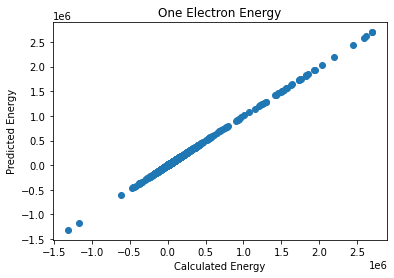

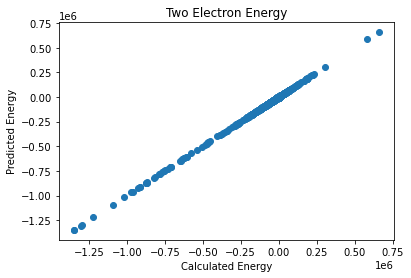

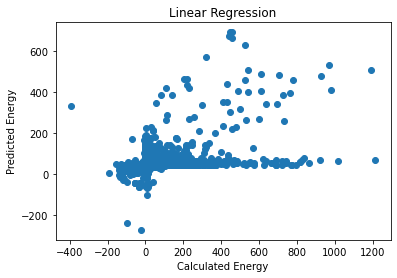

  -11.2200    42.2307 344.72
   61.7112    32.3191  62.52
   19.6516    42.6323  73.79
   19.6516    42.6323  73.79
    3.1397    42.0838 172.23
    3.1397    42.0838 172.23
    1.6184    43.2434 185.57
   26.0171    36.4652  33.44
  -19.4090    42.8385 531.36
   48.9302    35.1603  32.75
  -18.2083    32.7512 700.82
   24.6544    26.1528   5.90
  -83.5521    34.9486 -487.62
  -83.5521    34.9486 -487.62
  -36.9251    43.0541 2609.89
  -36.9251    43.0541 2609.89
  -23.6593    25.9349 4358.76
  -23.6593    25.9349 4358.76
   -8.0006    42.6829 292.27
   -8.0006    42.6829 292.27
 -110.1767    33.2098 -372.59
   18.6755    29.0109  43.35
  -32.8615    43.6496 1418.43
   29.0204    41.7942  36.08
  -69.0493    35.4785 -622.73
  -65.5552    35.0482 -659.54
  -42.5962    43.1832 29228.06
   37.1867    44.9112  18.82
  -17.3944    42.5316 476.79
   26.2415    43.6959  49.91
  -12.6034    42.6700 367.67
   48.7496    43.8807  10.51
   -2.4581    42.6253 224.48
   62.7969    43.6947  35.88
  

In [6]:
# test two linear models to predict energudiff
# LinearRegression
import sklearn.linear_model as lm
linearNR_Two = lm.LinearRegression()
linearNR_Two.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                  df["PBE_Two_Electron_Energy"])
print(linearNR_Two.coef_, linearNR_Two.intercept_)
linearNR_One = lm.LinearRegression()
linearNR_One.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                 df["PBE_One_Electron_Energy"])
print(linearNR_One.coef_, linearNR_One.intercept_)

Onepred = linearNR_One.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))
Twopred = linearNR_Two.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))

# scatter plot
plt.clf()
plt.scatter(df["PBE_One_Electron_Energy"], Onepred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('One Electron Energy')
plt.show()

plt.clf()
plt.scatter(df["PBE_Two_Electron_Energy"], Twopred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Two Electron Energy')
plt.show()

predEnergy = Onepred + Twopred + \
    df["PBE_Nuclear_Repulsion"].values
calculatedEnergy = df["PBE_Nuclear_Repulsion"].values + \
    df["PBE_One_Electron_Energy"].values + \
    df["PBE_Two_Electron_Energy"].values

# scatter plot
plt.clf()
plt.scatter(calculatedEnergy, predEnergy)    
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Linear Regression')
plt.show()

for i, ce in enumerate(calculatedEnergy):
    diff = abs(ce - predEnergy[i])/((ce+predEnergy[i])/2.0)
    print("%10.4f %10.4f %6.2f"%(ce, predEnergy[i], diff*100))

# PLSRegression using both one and two electron ?


In [7]:
featurestorms = set()
for tc in top_correlation:
    if tc not in featurestorms:
        for correlated in top_correlation[tc]:
            featurestorms.add(correlated[0])

print ("Features that are correlated with others and to remove")  
for idx, k in enumerate(featurestorms):
    print(idx+1 , " ", k)

Features that are correlated with others and to remove
1   PBE0_Potential_Energy
2   TPSS_Nuclear_Repulsion
3   PBE0_One_Electron_Energy
4   TPSS_FINAL_SINGLE_POINT_ENERGY
5   TPSSh_E(C)
6   TPSSh_One_Electron_Energy
7   PBE0_Nuclear_Repulsion
8   PBE0_E(X)
9   PBE0_Dispersion_correction
10   TPSSh_FINAL_SINGLE_POINT_ENERGY
11   TPSSh_Kinetic_Energy
12   TPSSh_Two_Electron_Energy
13   PBE_Nuclear_Repulsion
14   PBE0_FINAL_SINGLE_POINT_ENERGY
15   TPSS_E(X)
16   TPSS_E(C)
17   TPSSh_Potential_Energy
18   TPSS_Two_Electron_Energy
19   TPSS_Dispersion_correction
20   TPSSh_Nuclear_Repulsion
21   TPSS_Kinetic_Energy
22   TPSS_One_Electron_Energy
23   TPSSh_Dispersion_correction
24   TPSSh_E(X)
25   PBE0_Two_Electron_Energy
26   PBE0_E(C)
27   TPSS_Potential_Energy
28   PBE0_Kinetic_Energy
29   PBE_One_Electron_Energy


In [8]:
print ("Features TO USE")
idx = 1
for f in allfeatures:
    if f not in featurestorms:
        print(idx, f) 
        idx += 1 

Features TO USE
1 PBE_E(C)
2 PBE_Two_Electron_Energy
3 PBE_Dispersion_correction
4 PBE_Potential_Energy
5 PBE_FINAL_SINGLE_POINT_ENERGY
6 PBE_E(X)
7 PBE_Kinetic_Energy


In [9]:
featurestorm = list(featurestorms)

for setname in fullsetnames:
    commonutils.remove_features_fromset(allvalues_perset[setname], \
                                            list(featurestorm), \
                                            methods)

for setname in fullsetnames:
    models_results[setname].fulldescriptors = []
    models_results[setname].labels = []
    models_results[setname].setname = []
    models_results[setname].supersetname = []
    for idx, val in enumerate(allvalues_perset[setname]):
        models_results[setname].fulldescriptors.append({})
        for method in methods:
            if method+"_energydiff" in val:
                models_results[setname].fulldescriptors[idx].update(\
                    val[method+"_energydiff"])

        models_results[setname].labels.append(val["label"])
        models_results[setname].setname.append(val["setname"])
        models_results[setname].supersetname.append(val["super_setname"])

setname = "Full"
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

Correlation matrix


<AxesSubplot:>

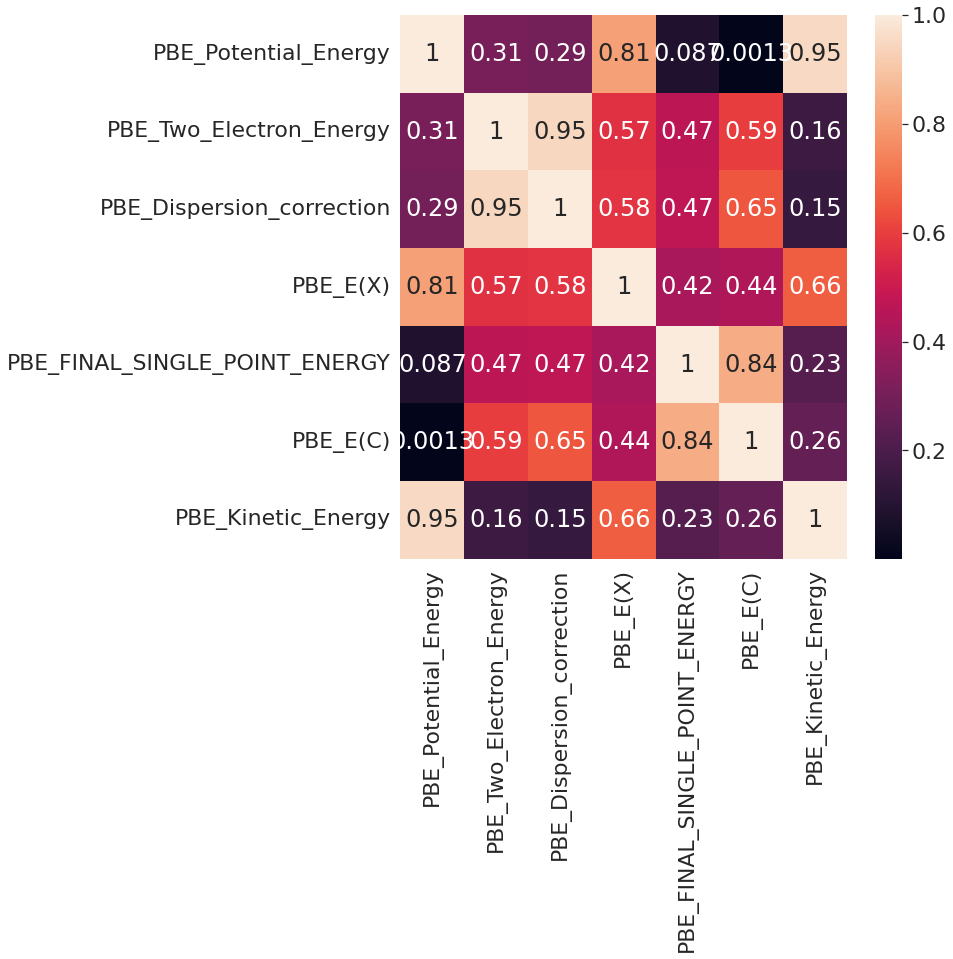

In [10]:
import seaborn as sns
%matplotlib inline
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [11]:
# CHECK WTAAD2 Calculation for reference methods (wtaad2_ref):
for setname in models_results:
    if setname in supersetnames:
        predicted = models_results[setname].y_pred_bestourmethod
        labels = models_results[setname].labels
        setlist = []
        for i, s in enumerate(models_results[setname].setname):
            ss = models_results[setname].supersetname[i]
            setlist.append(ss + "_" + s)   
        supersetlist = models_results[setname].supersetname

        wtmad = commonutils.wtmad_calc(supersetlist, setlist, predicted, labels, includeFull = False)
        print("WTMAD for ", setname, " and model ", \
              models_results[setname].bestourmethod, "\n")
        pp.pprint(wtmad)
        print(setname)

WTMAD for  BARRIER_HEIGHTS  and model  TPSSh 

          Superset  WTMAD-2_Predicted
0  BARRIER_HEIGHTS              22.51
BARRIER_HEIGHTS
WTMAD for  INTRAMOLECULAR_INTERACTIONS  and model  PBE0 

                      Superset  WTMAD-2_Predicted
0  INTRAMOLECULAR_INTERACTIONS                4.5
INTRAMOLECULAR_INTERACTIONS
WTMAD for  SMALL_MOLECULES  and model  PBE 

          Superset  WTMAD-2_Predicted
0  SMALL_MOLECULES              61.11
SMALL_MOLECULES
WTMAD for  INTERMOLECULAR_INTERACTIONS  and model  TPSSh 

                      Superset  WTMAD-2_Predicted
0  INTERMOLECULAR_INTERACTIONS             123.68
INTERMOLECULAR_INTERACTIONS
WTMAD for  LARGE_SYSTEMS  and model  TPSS 

        Superset  WTMAD-2_Predicted
0  LARGE_SYSTEMS              39.54
LARGE_SYSTEMS


In [12]:
# search for the best model a simple grid search
#nepochs = [50, 100]
nepochs = [100]
#batch_sizes = [4, 8, 16, 32]
batch_sizes = [16, 32]
#modelshapes = [[4, 4], [8, 8], [16, 16], \
#                [32, 32], [64, 64], [128, 128], \
#                [4, 4, 4], [8, 8, 8], [16, 16, 16], \
#                [32, 32, 32], [64, 64, 64], \
#                [128, 128, 128], [4, 4, 4, 4], \
#                [8, 8, 8, 8], [16, 16, 16, 16], \
#                [32, 32, 32, 32], [64, 64, 64, 64], \
#                [128, 128, 128, 128]]
modelshapes = [[4, 4, 4], [8, 8, 8], [16, 16, 16], \
                [32, 32, 32], [64, 64, 64], \
                [128, 128, 128], [4, 4, 4, 4], \
                [8, 8, 8, 8], [16, 16, 16, 16], \
                [32, 32, 32, 32], [64, 64, 64, 64], \
                [128, 128, 128, 128], [4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8], [16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32], [64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128], [4, 4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8, 8], [16, 16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32, 32], [64, 64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128, 128]]
for setname in list(supersetnames) + ["Full"]:
        print("Searching for best NN model for set: ", setname)
        X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
        scalerx = preprocessing.StandardScaler().fit(X)
        X_s = scalerx.transform(X) 
        scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
        Y_s = scalery.transform(Y.reshape(-1, 1))
        modelminmape, modelminrmse = \
                models.nn_model(0.2, X_s, Y_s, \
                    nepochs, modelshapes, batch_sizes, inputshape=-1,\
                    search=True)
    
        print("Best NN model for set: ", setname, file=sys.stderr)
        print("  RMSE: ", modelminrmse, file=sys.stderr)
        print("  MAPE: ", modelminmape, file=sys.stderr)

        models_results[setname].modelminmape = modelminmape
        models_results[setname].modelminrmse = modelminrmse

Searching for best NN model for set:  BARRIER_HEIGHTS
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Searching for best NN model for set:  INTRAMOLECULAR_INTERACTIONS


Best NN model for set:  BARRIER_HEIGHTS
  RMSE:  ([128, 128, 128, 128, 128, 128], 100, 32)
  MAPE:  ([32, 32, 32], 100, 16)


Progress: |██████████████████████████████████████████████████| 100.0% Complete
Searching for best NN model for set:  SMALL_MOLECULES


Best NN model for set:  INTRAMOLECULAR_INTERACTIONS
  RMSE:  ([128, 128, 128, 128, 128], 100, 16)
  MAPE:  ([32, 32, 32, 32], 100, 32)


Progress: |██████████████████████████████████████████████████| 100.0% Complete
Searching for best NN model for set:  INTERMOLECULAR_INTERACTIONS


Best NN model for set:  SMALL_MOLECULES
  RMSE:  ([128, 128, 128, 128, 128], 100, 32)
  MAPE:  ([64, 64, 64, 64, 64], 100, 16)


Progress: |██████████████████████████████████████████████████| 100.0% Complete
Searching for best NN model for set:  LARGE_SYSTEMS


Best NN model for set:  INTERMOLECULAR_INTERACTIONS
  RMSE:  ([128, 128, 128, 128], 100, 32)
  MAPE:  ([128, 128, 128, 128, 128], 100, 32)


Progress: |██████████████████████████████████████████████████| 100.0% Complete
Searching for best NN model for set:  Full


Best NN model for set:  LARGE_SYSTEMS
  RMSE:  ([32, 32, 32, 32, 32, 32], 100, 32)
  MAPE:  ([32, 32, 32], 100, 16)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


Best NN model for set:  Full
  RMSE:  ([64, 64, 64, 64], 100, 32)
  MAPE:  ([16, 16, 16, 16, 16], 100, 16)


In [13]:
import importlib
importlib.reload(models)

for setname in list(supersetnames) + ["Full"]:
        modelminmape = models_results[setname].modelminmape 
        modelminrmse = models_results[setname].modelminrmse
        X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
        scalerx = preprocessing.StandardScaler().fit(X)
        X_s = scalerx.transform(X) 
        scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
        Y_s = scalery.transform(Y.reshape(-1, 1))
        #build the final model and print the results
        results_mape = models.nn_model(0.2, X_s, Y_s, \
                    [modelminmape[1]], \
                    [modelminmape[0]], \
                    [modelminmape[2]], \
                    inputshape=-1,\
                    search=False)
        
        models_results[setname].nn_model_mape = results_mape

        results_rmse = models.nn_model(0.2, X_s, Y_s, \
                    [modelminrmse[1]], \
                    [modelminrmse[0]], \
                    [modelminrmse[2]], \
                    inputshape=-1,\
                    search=False)
        
        models_results[setname].nn_model_rmse = results_rmse

48/48 [==============================] - 0s 350us/step


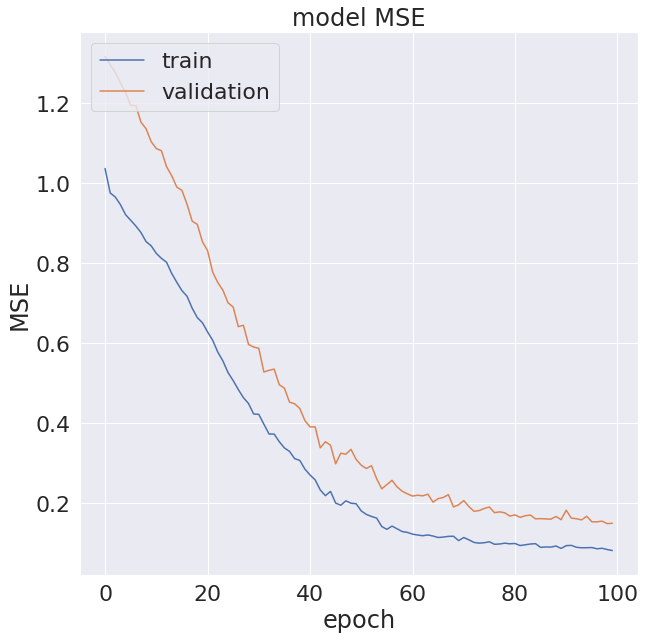

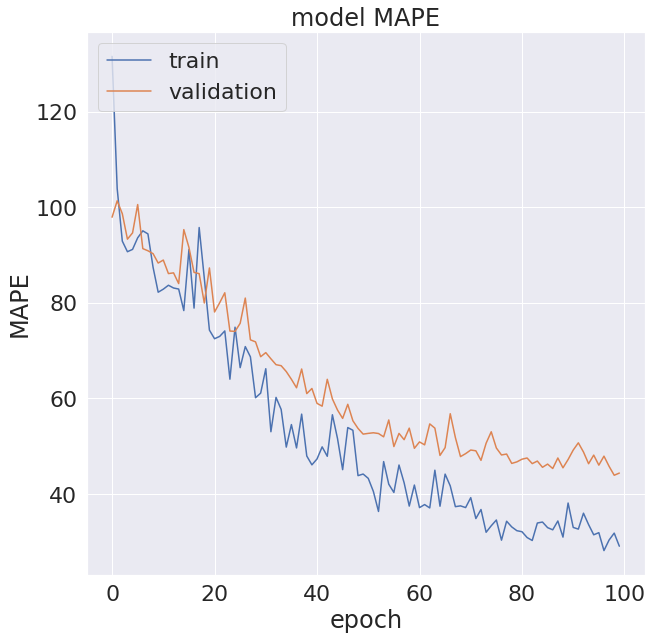

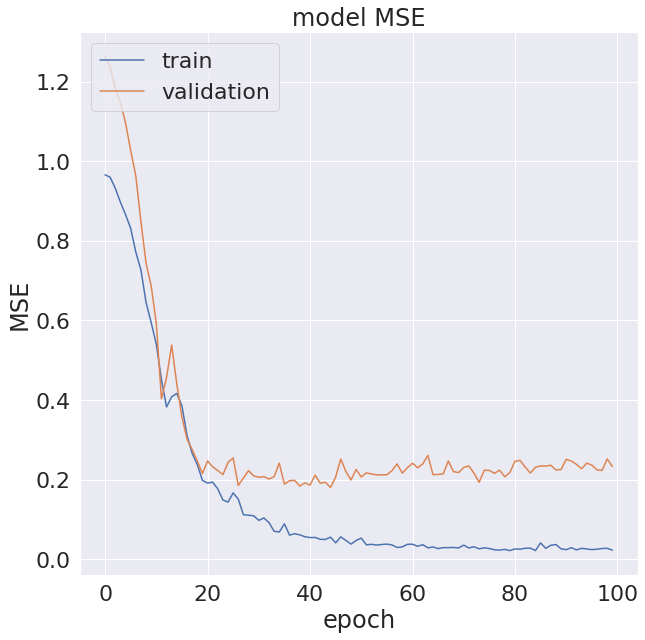

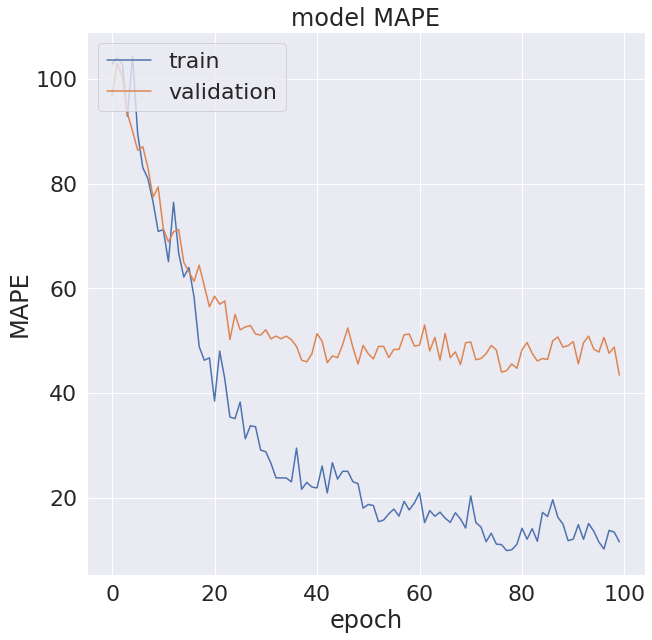

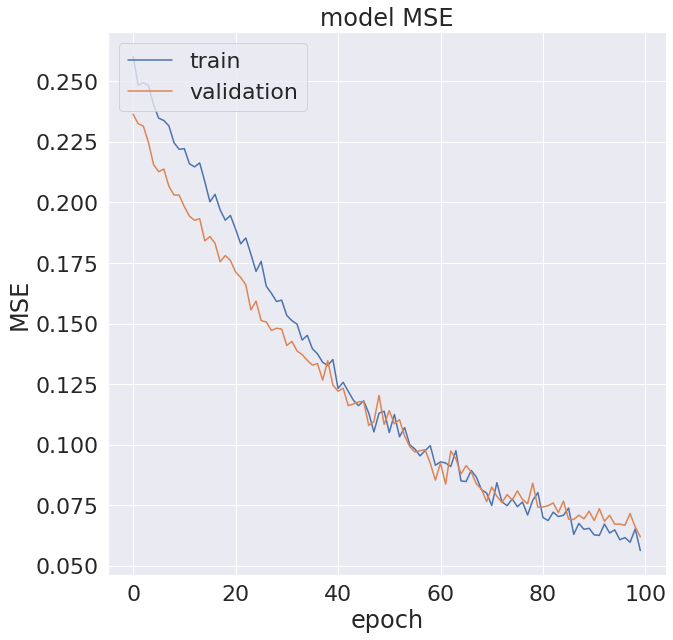

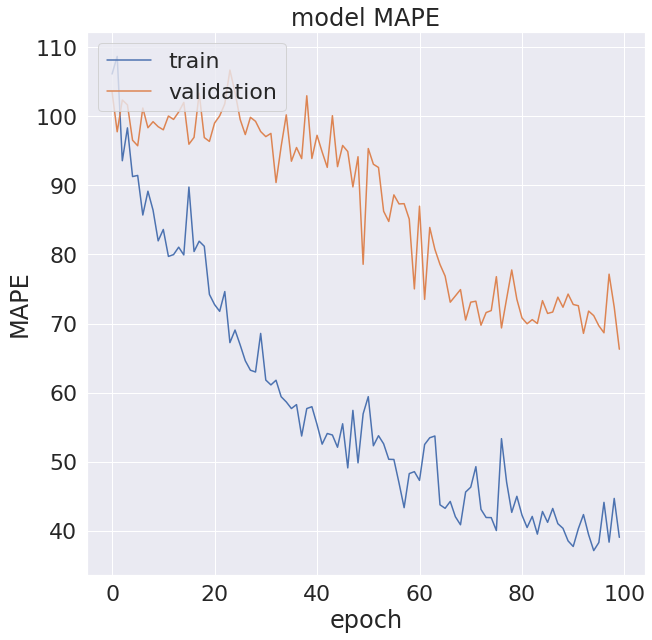

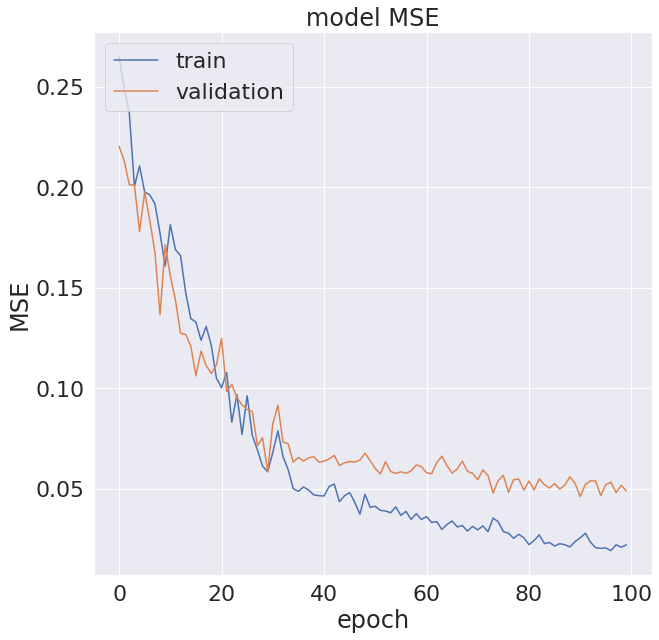

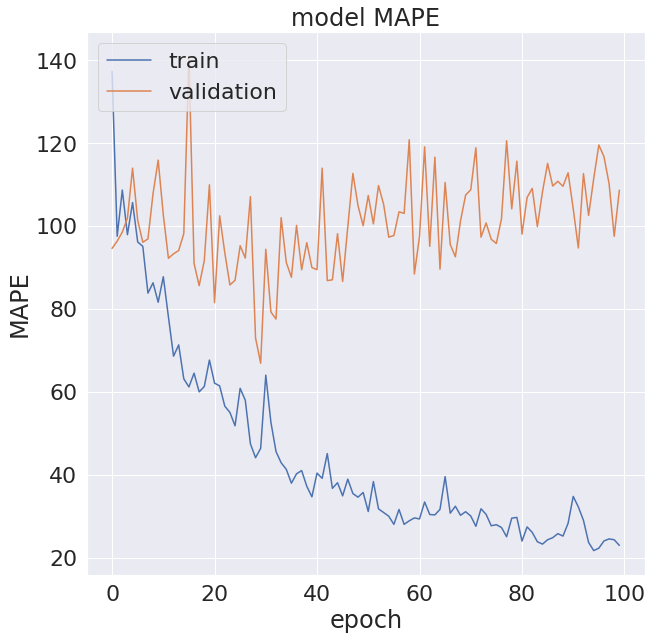

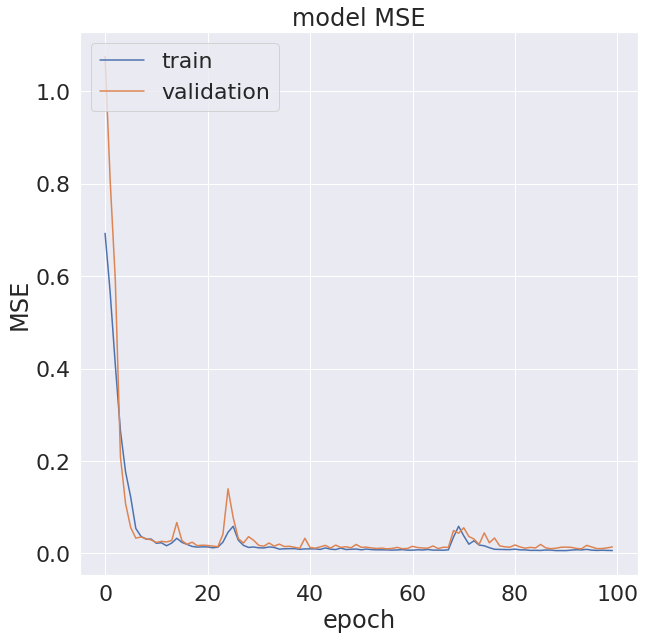

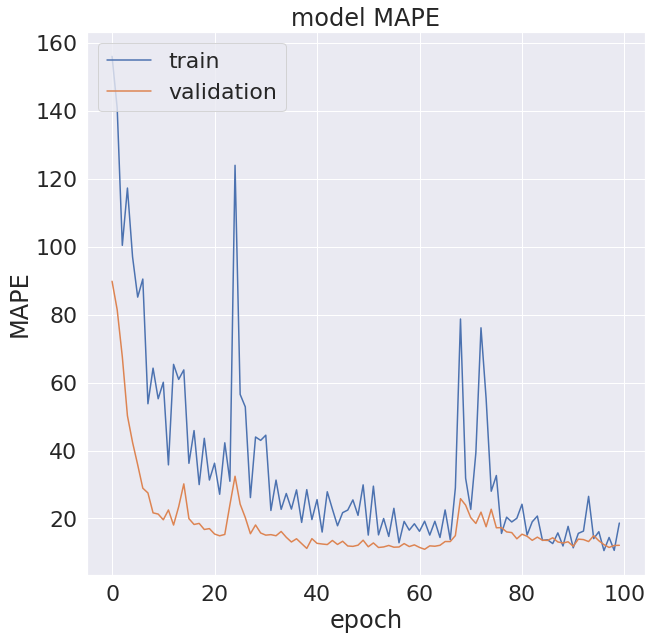

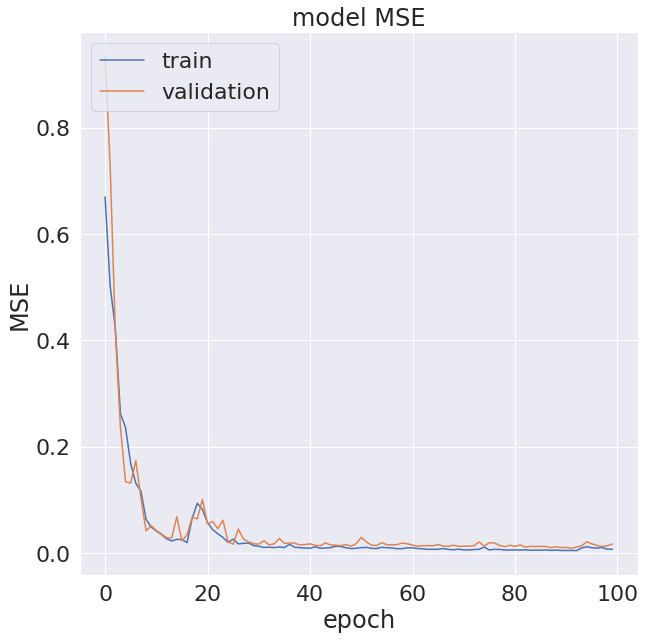

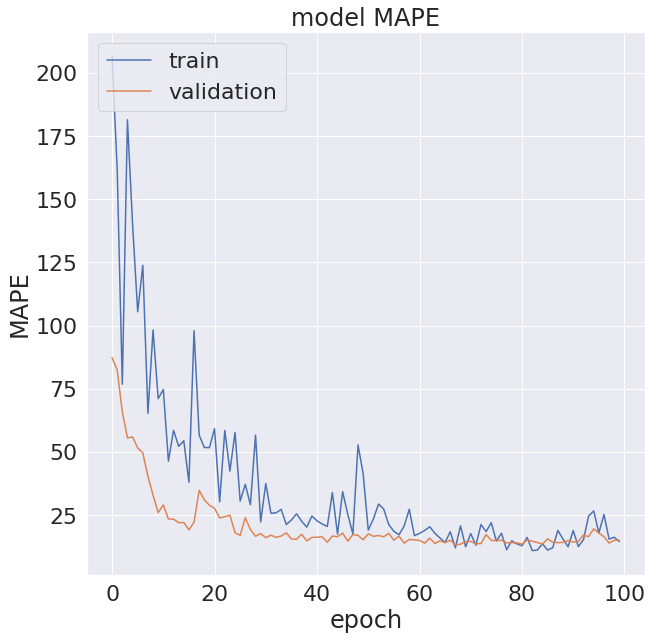

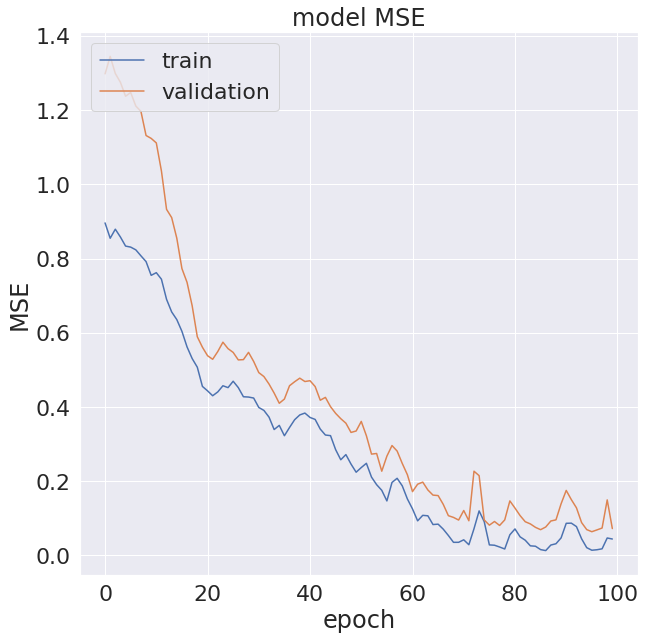

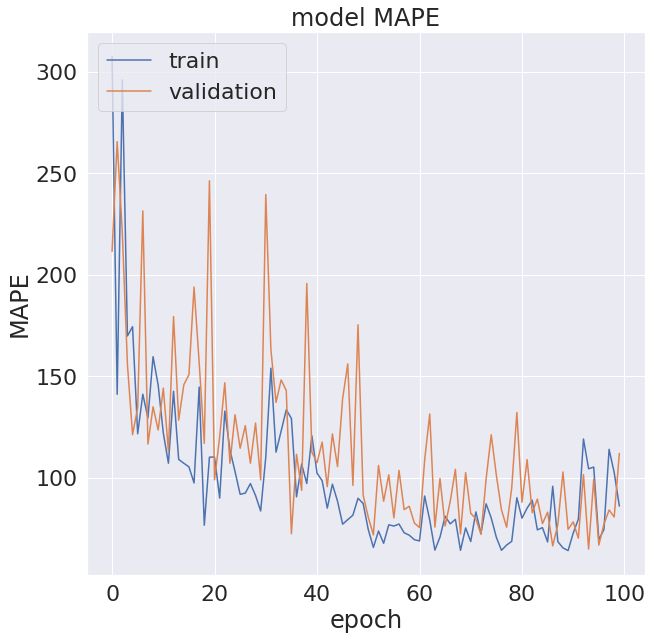

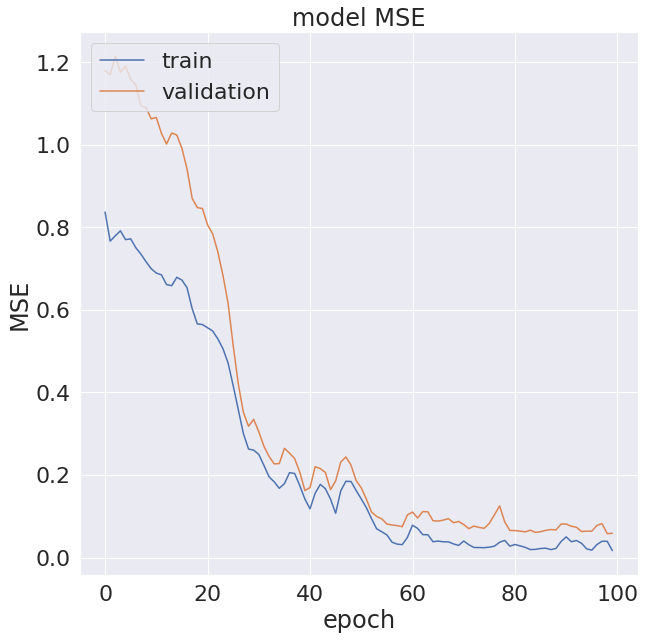

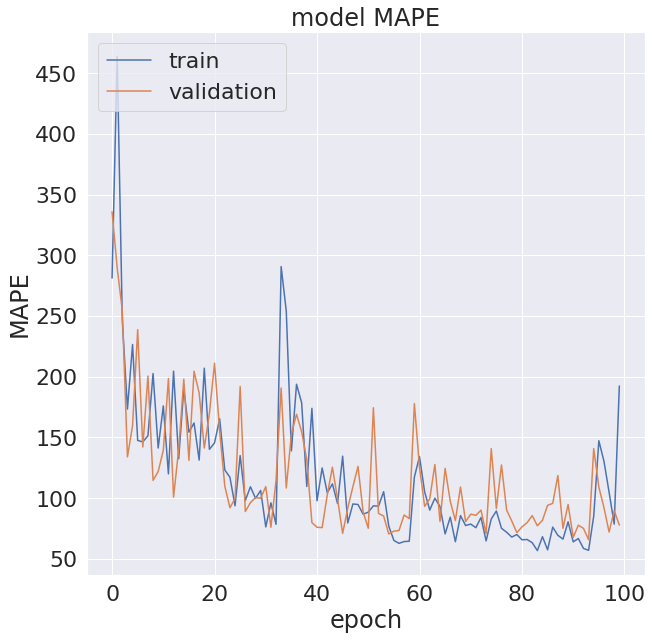

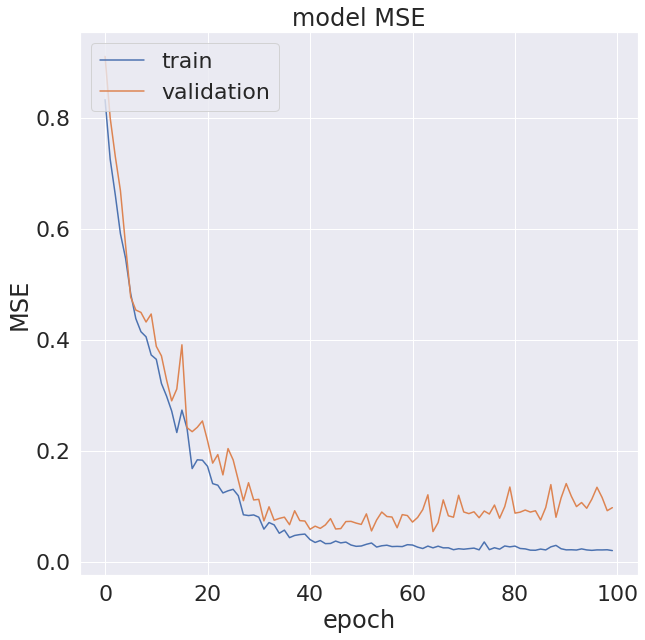

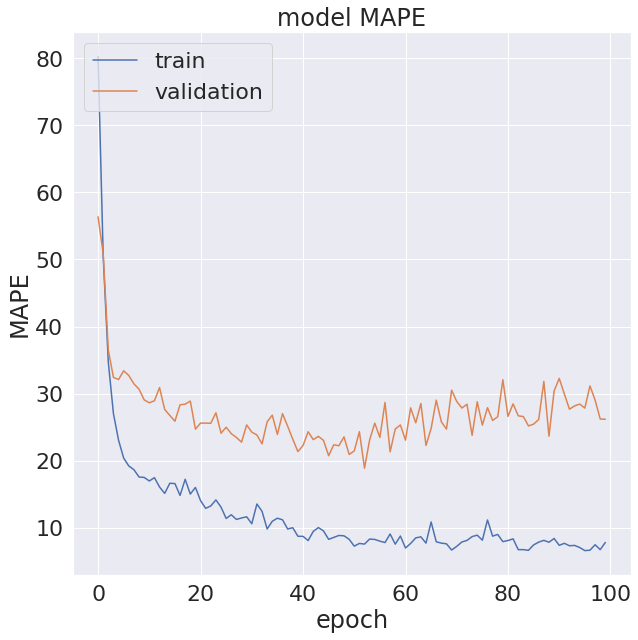

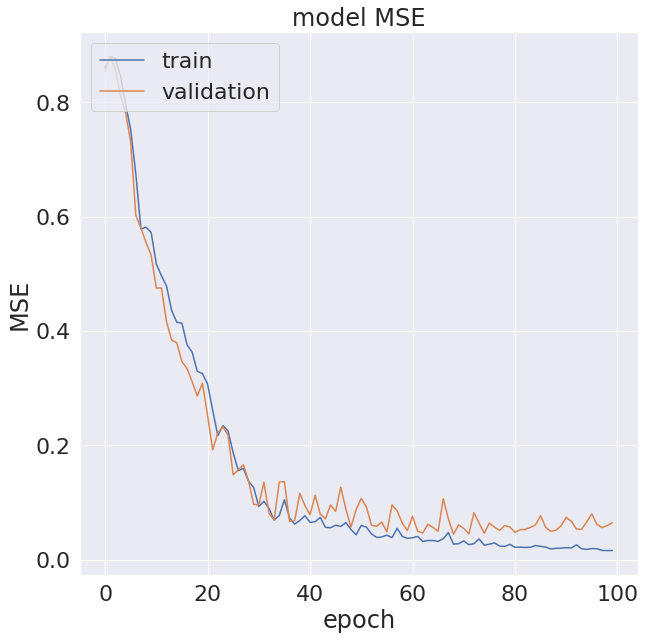

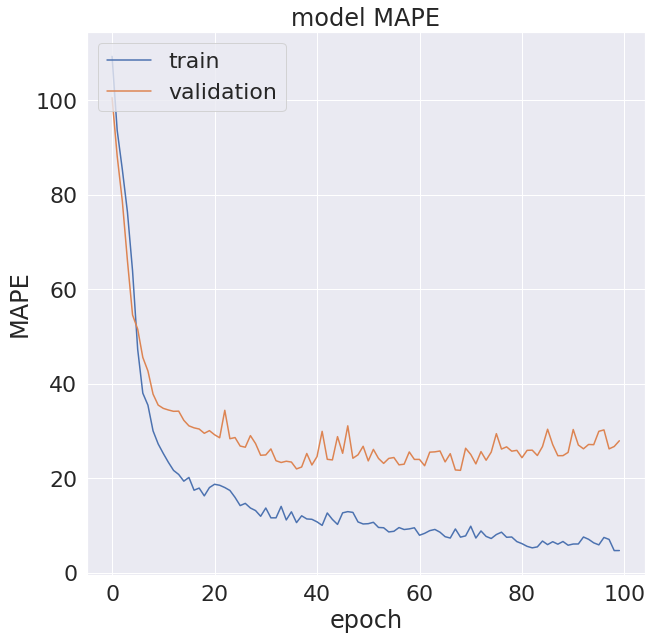

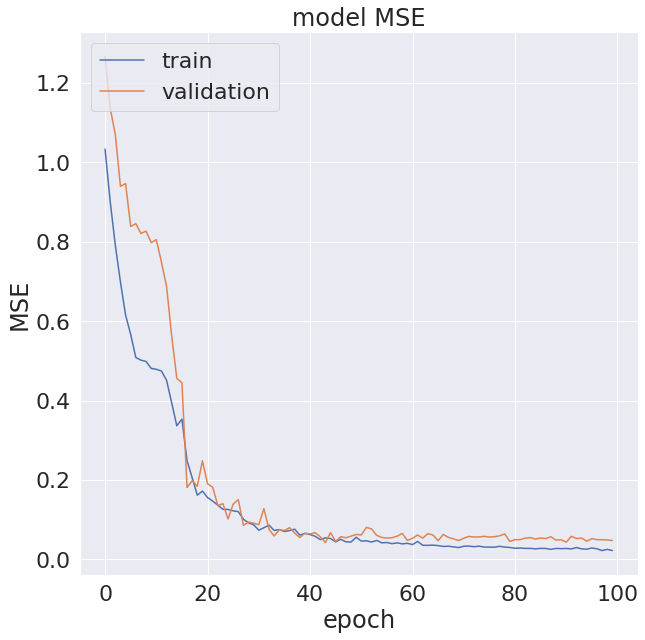

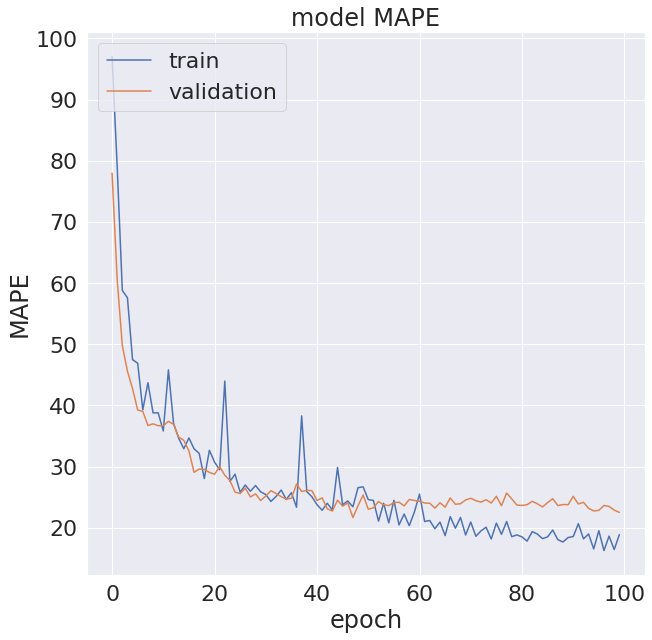

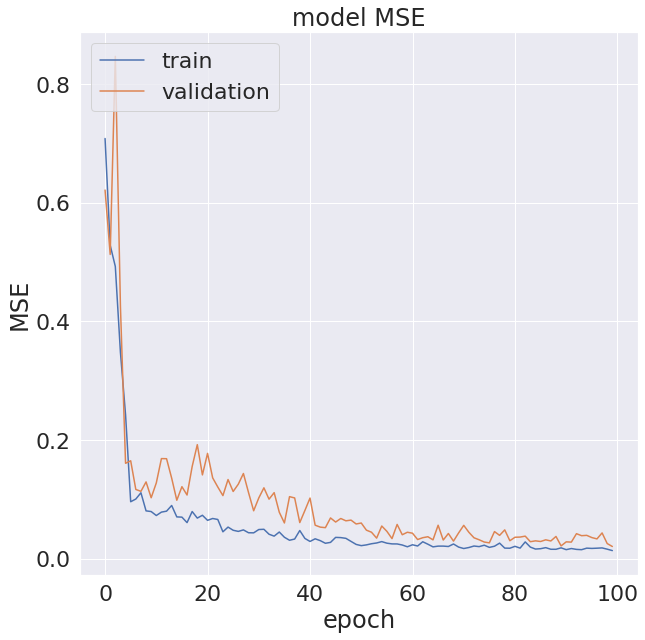

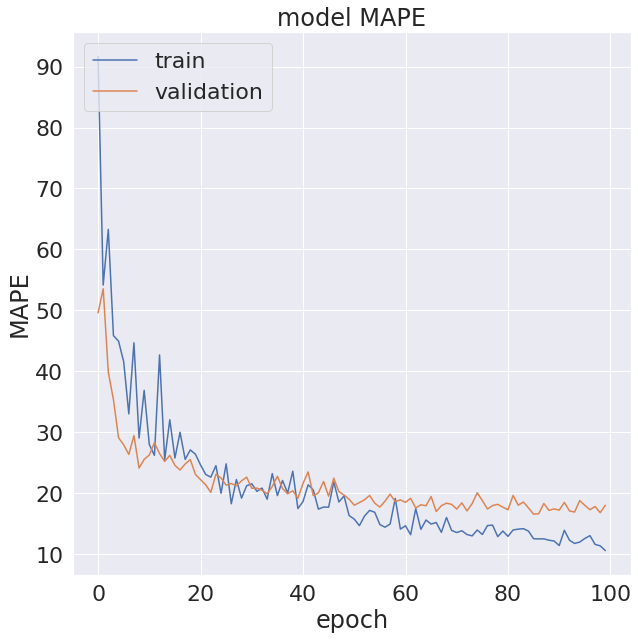

In [14]:
for setname in list(supersetnames) + ["Full"]:
    results_mape = models_results[setname].nn_model_mape
    results_rmse = models_results[setname].nn_model_rmse
    # summarize history for accuracy
    history = results_mape['history']
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model MSE')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.title('model MAPE')
    plt.ylabel('MAPE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # summarize history for accuracy
    history = results_rmse['history']
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model MSE')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.title('model MAPE')
    plt.ylabel('MAPE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [15]:
#denomrlize the results
"""
plt.clf()
plt.scatter(results_mape['y_full'], \
            results_mape['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results_mape['y_pred_full'])
y_full = scalery.inverse_transform(results_mape['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#denomrlize the results
plt.clf()
plt.scatter(results_rmse['y_full'], \
            results_rmse['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results_rmse['y_pred_full'])
y_full = scalery.inverse_transform(results_rmse['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
"""

'\nplt.clf()\nplt.scatter(results_mape[\'y_full\'],             results_mape[\'y_pred_full\'])\nplt.xlabel(\'True Values\')\nplt.ylabel(\'Predictions\')\nplt.show()\ny_pred_full = scalery.inverse_transform(results_mape[\'y_pred_full\'])\ny_full = scalery.inverse_transform(results_mape[\'y_full\'])\nrmse_full = mean_squared_error(y_full, y_pred_full, squared=False)\nr2_full = r2_score(y_full, y_pred_full)\nprint("RMSE Full      : %5.2f"%rmse_full)\nprint("R2 Full        : %5.2f"%r2_full)\n\n# plot the results\nplt.clf()\nplt.scatter(y_full, y_pred_full)\nplt.xlabel(\'True Values\')\nplt.ylabel(\'Predictions\')\nplt.show()\n\n#denomrlize the results\nplt.clf()\nplt.scatter(results_rmse[\'y_full\'],             results_rmse[\'y_pred_full\'])\nplt.xlabel(\'True Values\')\nplt.ylabel(\'Predictions\')\nplt.show()\ny_pred_full = scalery.inverse_transform(results_rmse[\'y_pred_full\'])\ny_full = scalery.inverse_transform(results_rmse[\'y_full\'])\nrmse_full = mean_squared_error(y_full, y_pred_

In [16]:
from sklearn.metrics import mean_absolute_percentage_error
setname = "Full"
results_mape = models_results[setname].nn_model_mape
results_rmse = models_results[setname].nn_model_rmse
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE Full , RMSE sset , ", \
      "RMSE Full mape, RMSE sset mape" )
for setname in fullsetnames:
    ssetname = "Full"
    if setname in supersetnames or setname == "Full":
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]

    results_mape_sset = models_results[ssetname].nn_model_mape
    results_sset = models_results[ssetname].nn_model_rmse
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))

    y_pred_mape = scalery.inverse_transform(results_mape['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_mape = y_pred_mape
    rmse_mape = mean_squared_error(Y, y_pred_mape, squared=False)
    #r2 = r2_score(Y, y_pred_mape)
    #mape = mean_absolute_percentage_error(Y, y_pred_mape)
    
    y_pred = scalery.inverse_transform(results_rmse['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred = y_pred
    rmse = mean_squared_error(Y, y_pred, squared=False)
    
    y_pred_mape_sset = scalery.inverse_transform(results_mape_sset['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_mape_sset = y_pred_mape_sset
    rmse_mape_sset = mean_squared_error(Y, y_pred_mape_sset, squared=False)
    
    y_pred_sset = scalery.inverse_transform(results_sset['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_sset = y_pred_sset
    rmse_sset = mean_squared_error(Y, y_pred_sset, squared=False)
    
    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%rmse_sset, " , ", \
        "%7.3f"%rmse_mape, " , ", \
        "%7.3f"%rmse_mape_sset)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE Full , RMSE sset ,  RMSE Full mape, RMSE sset mape
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,   27.068  ,    8.327  ,   55.159  ,    9.936  ,   24.645
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,   31.874  ,   10.788  ,   53.234  ,   10.372  ,   19.320
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,   14.757  ,    6.338  ,   51.310  ,   13.959  ,   32.106
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,   17.811  ,    6.079  ,   42.671  ,    4.612  ,   24.283
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    2.686  ,    1.943  ,   57.339  ,    1.818  ,   11.478
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    5.711  ,    7.140  ,   63.836  ,    8.290  ,   25.067
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,   49.956  ,   11.187  ,   67.565  ,   20.906  ,   40.994

In [17]:
"""
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , MAPE, R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred = scalery.inverse_transform(results_rmse['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred = y_pred
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    mape = mean_absolute_percentage_error(Y, y_pred)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%mape, " , ", \
        "%7.3f"%r2)
"""

'\nprint(" Dim , %40s"% "Dataset", " , ",       "Best inside method RMSE", " , ",       "Best our method RMSE", " , ",       "RMSE , MAPE, R2")\nfor setname in fullsetnames:\n    X, Y, features_names =             commonutils.build_XY_matrix (models_results[setname].fulldescriptors,                                     models_results[setname].labels)\n    \n    X_s = scalerx.transform(X)\n    Y_s = scalery.transform(Y.reshape(-1, 1))\n    y_pred = scalery.inverse_transform(results_rmse[\'model\'].predict(X_s, verbose=0))\n    models_results[setname].y_pred = y_pred\n    rmse = mean_squared_error(Y, y_pred, squared=False)\n    r2 = r2_score(Y, y_pred)\n    mape = mean_absolute_percentage_error(Y, y_pred)\n\n    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ",         "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ",         "%7.3f"%models_results[setname].bestourmethod_rmse, " , ",         "%7.3f"%rmse, " , ",         "%7.3f"%mape, " , ",         "%7.

RMSE             (full)   8.327
RMSE             (sset)  55.159
RMSE (bestinsidemethod)   8.201
RMSE    (bestourmethod)  27.068


<Figure size 720x720 with 0 Axes>

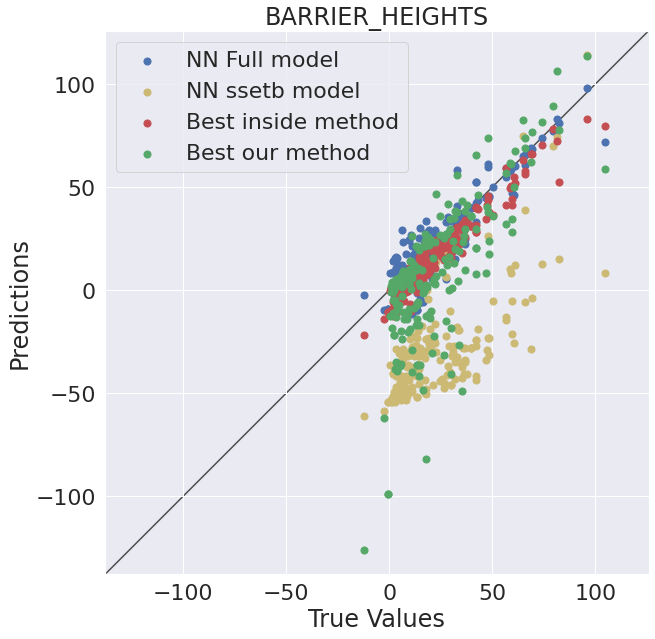

RMSE             (full)  10.788
RMSE             (sset)  53.234
RMSE (bestinsidemethod)  10.387
RMSE    (bestourmethod)  31.874


<Figure size 720x720 with 0 Axes>

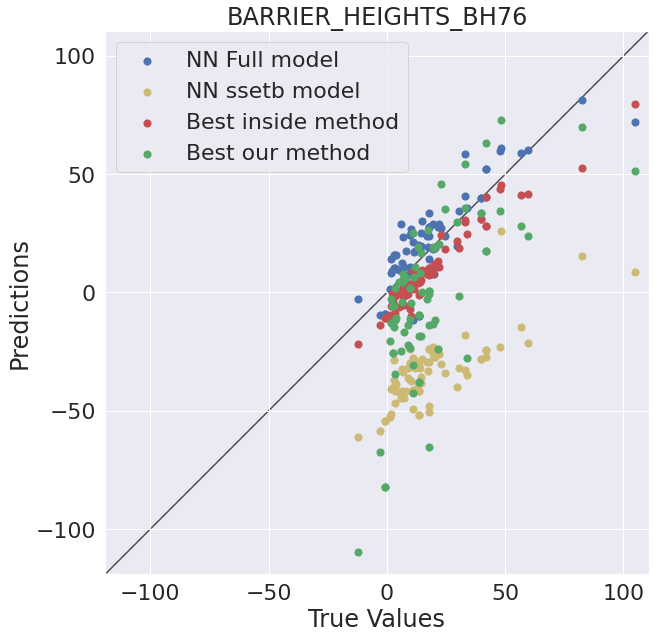

RMSE             (full)   6.338
RMSE             (sset)  51.310
RMSE (bestinsidemethod)   9.191
RMSE    (bestourmethod)  14.757


<Figure size 720x720 with 0 Axes>

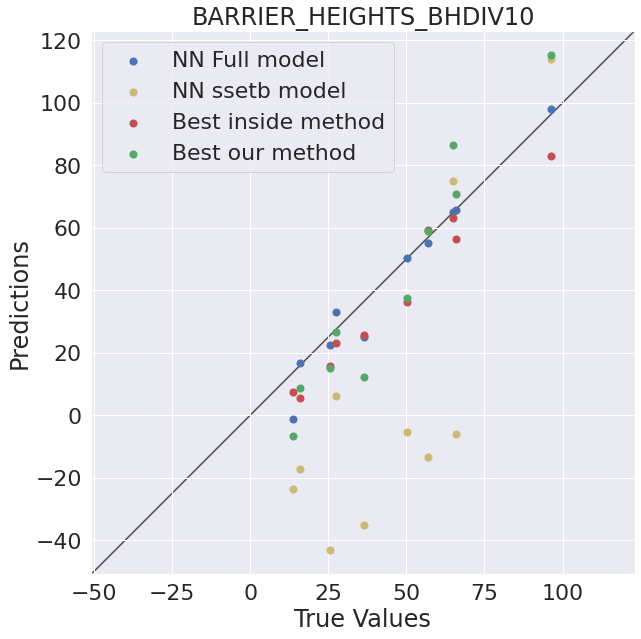

RMSE             (full)   6.079
RMSE             (sset)  42.671
RMSE (bestinsidemethod)   4.407
RMSE    (bestourmethod)  17.811


<Figure size 720x720 with 0 Axes>

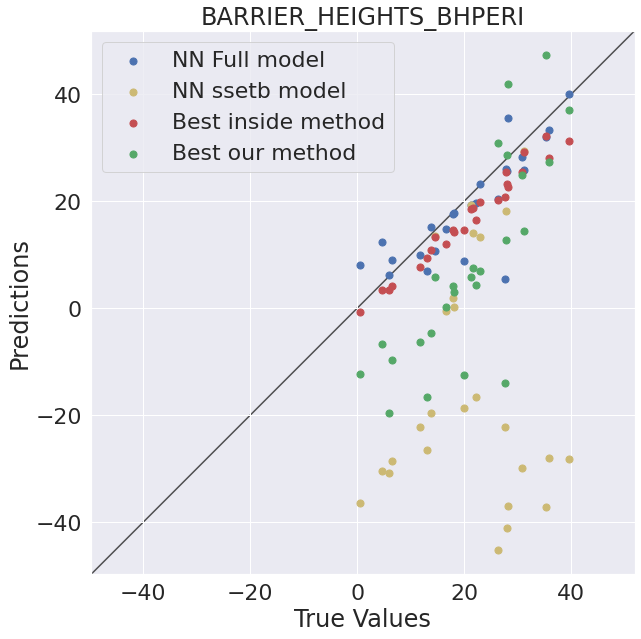

RMSE             (full)   1.943
RMSE             (sset)  57.339
RMSE (bestinsidemethod)   0.611
RMSE    (bestourmethod)   2.686


<Figure size 720x720 with 0 Axes>

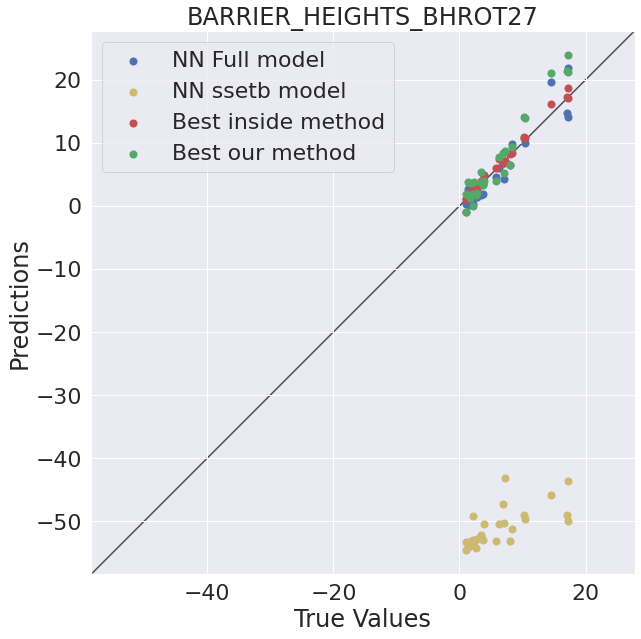

RMSE             (full)   7.140
RMSE             (sset)  63.836
RMSE (bestinsidemethod)   2.658
RMSE    (bestourmethod)   5.711


<Figure size 720x720 with 0 Axes>

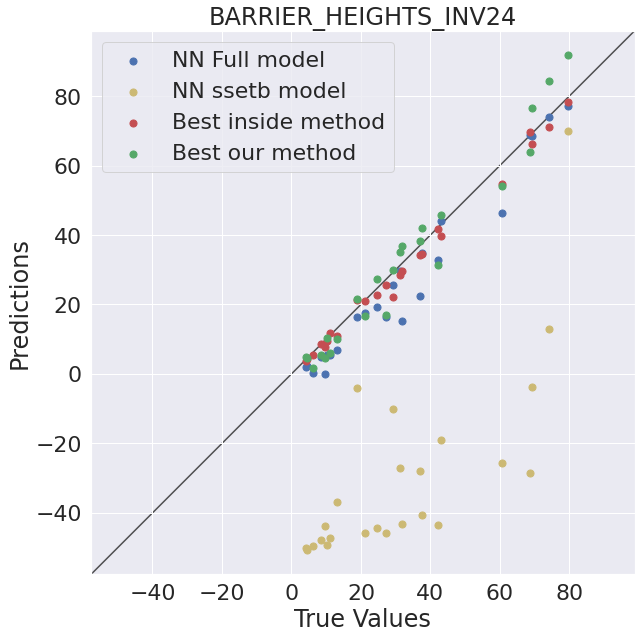

RMSE             (full)  11.187
RMSE             (sset)  67.565
RMSE (bestinsidemethod)  11.730
RMSE    (bestourmethod)  49.956


<Figure size 720x720 with 0 Axes>

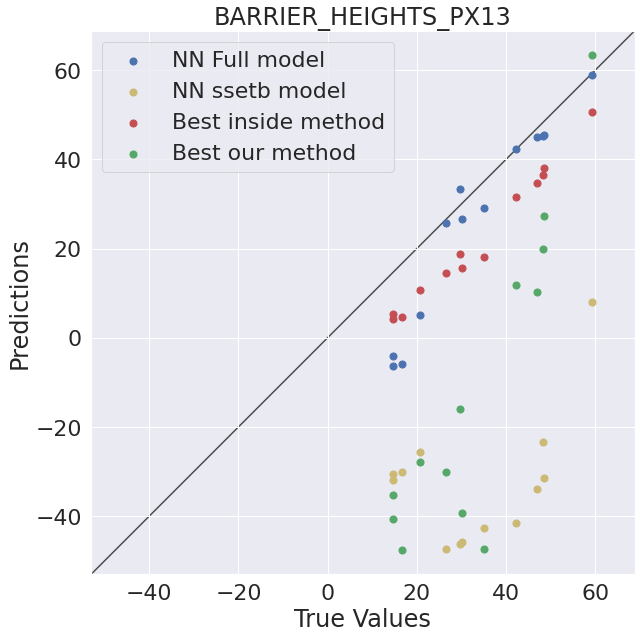

RMSE             (full)   4.019
RMSE             (sset)  55.421
RMSE (bestinsidemethod)   8.999
RMSE    (bestourmethod)  24.302


<Figure size 720x720 with 0 Axes>

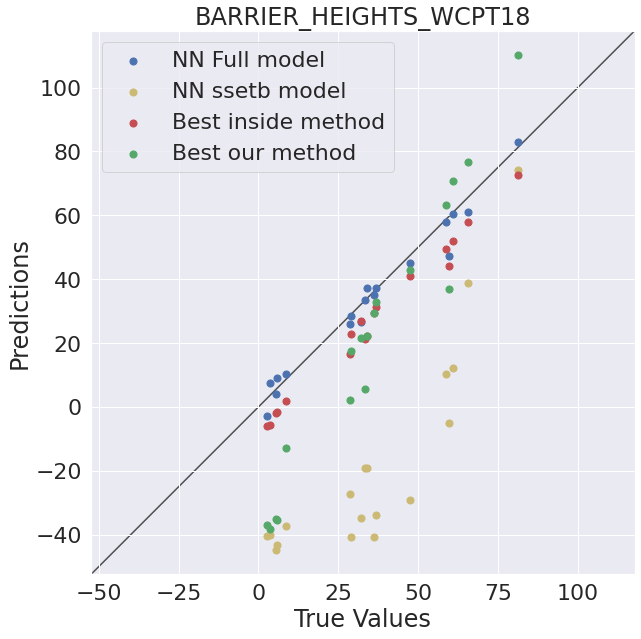

RMSE             (full)   2.193
RMSE             (sset)  13.295
RMSE (bestinsidemethod)   0.873
RMSE    (bestourmethod)   4.499


<Figure size 720x720 with 0 Axes>

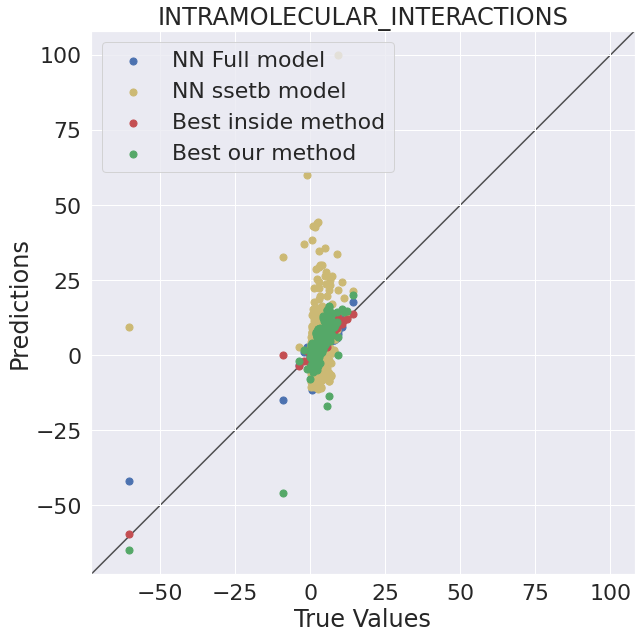

RMSE             (full)   0.382
RMSE             (sset)  13.903
RMSE (bestinsidemethod)   0.090
RMSE    (bestourmethod)   1.250


<Figure size 720x720 with 0 Axes>

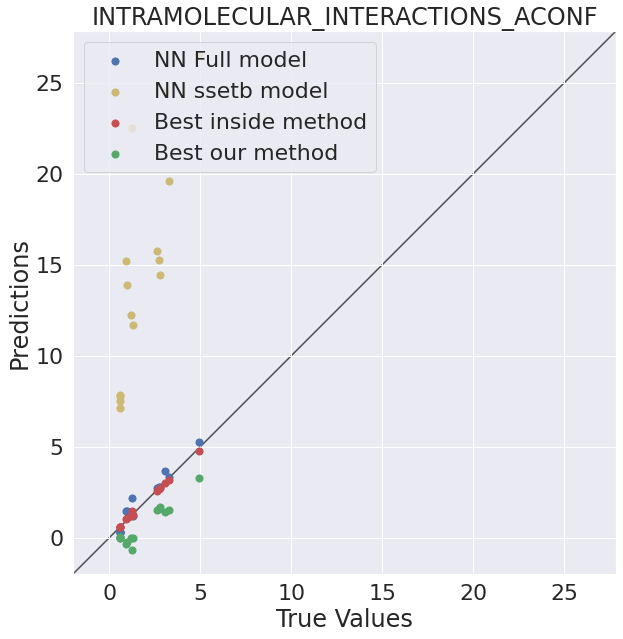

RMSE             (full)   1.423
RMSE             (sset)   8.712
RMSE (bestinsidemethod)   0.375
RMSE    (bestourmethod)   2.559


<Figure size 720x720 with 0 Axes>

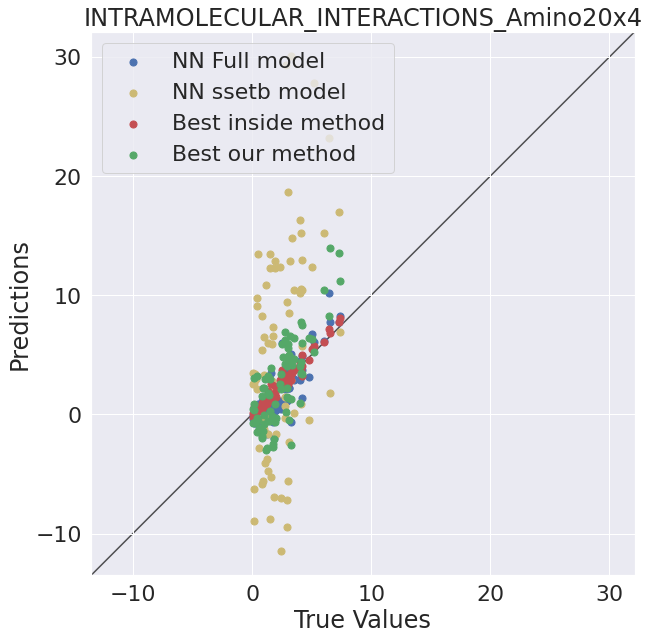

RMSE             (full)   0.674
RMSE             (sset)   4.511
RMSE (bestinsidemethod)   0.349
RMSE    (bestourmethod)   4.486


<Figure size 720x720 with 0 Axes>

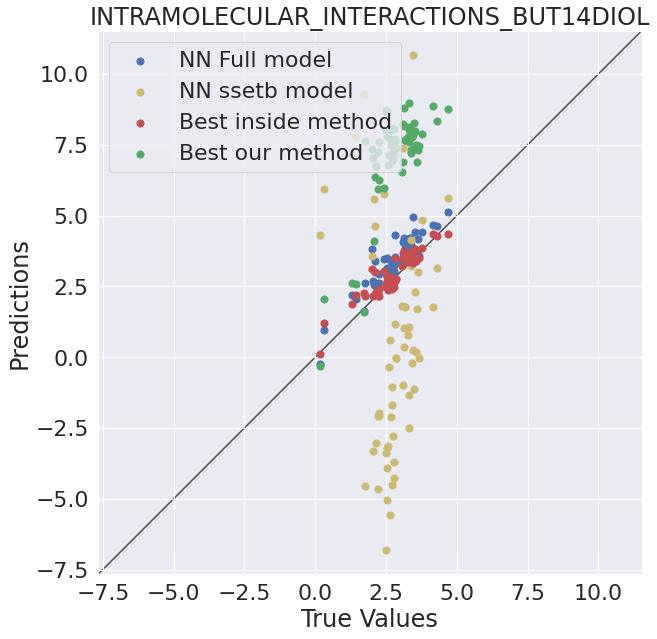

RMSE             (full)   2.403
RMSE             (sset)   5.993
RMSE (bestinsidemethod)   0.450
RMSE    (bestourmethod)   1.496


<Figure size 720x720 with 0 Axes>

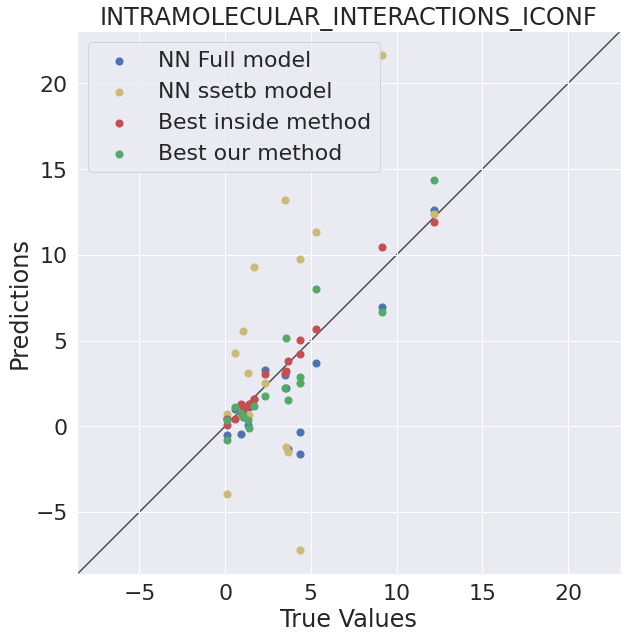

RMSE             (full)   8.079
RMSE             (sset)  57.976
RMSE (bestinsidemethod)   4.154
RMSE    (bestourmethod)  11.849


<Figure size 720x720 with 0 Axes>

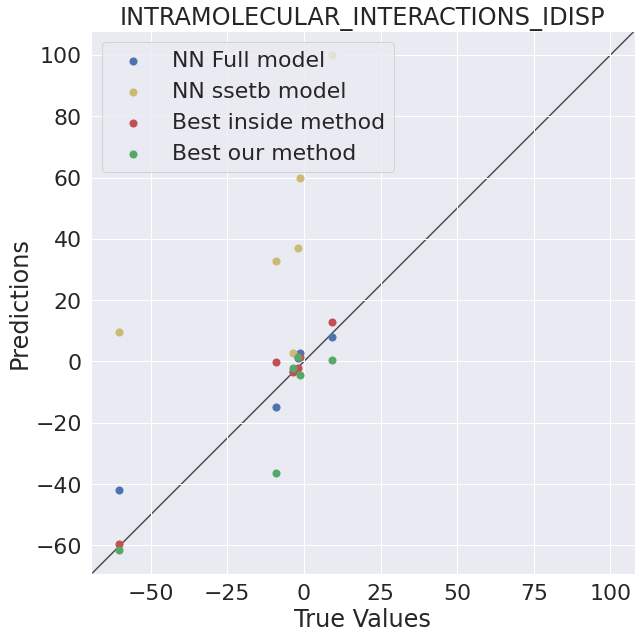

RMSE             (full)   1.587
RMSE             (sset)   8.251
RMSE (bestinsidemethod)   0.480
RMSE    (bestourmethod)   1.902


<Figure size 720x720 with 0 Axes>

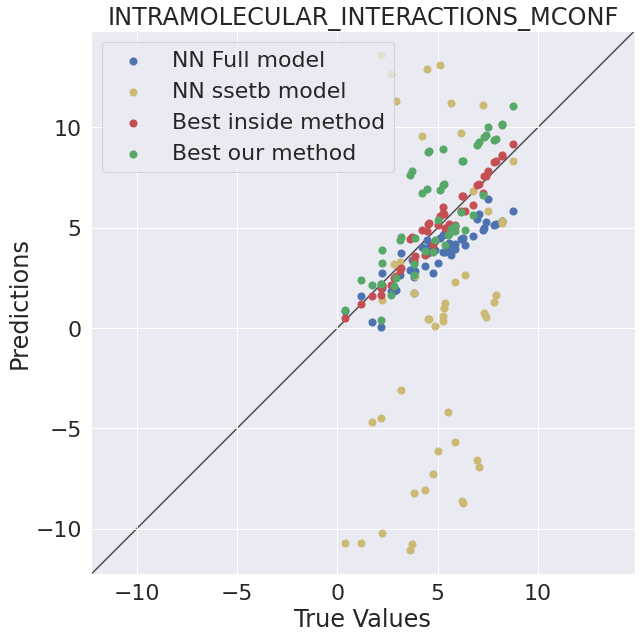

RMSE             (full)   2.155
RMSE             (sset)  21.280
RMSE (bestinsidemethod)   1.286
RMSE    (bestourmethod)   4.008


<Figure size 720x720 with 0 Axes>

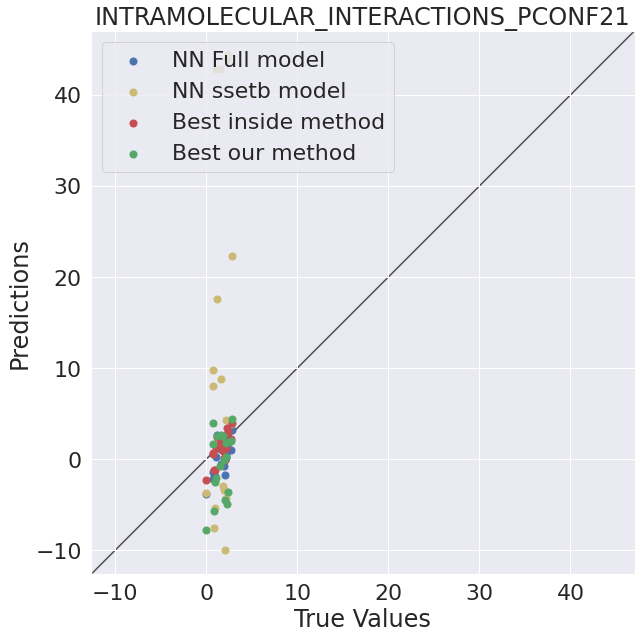

RMSE             (full)   3.608
RMSE             (sset)   8.265
RMSE (bestinsidemethod)   0.472
RMSE    (bestourmethod)  10.187


<Figure size 720x720 with 0 Axes>

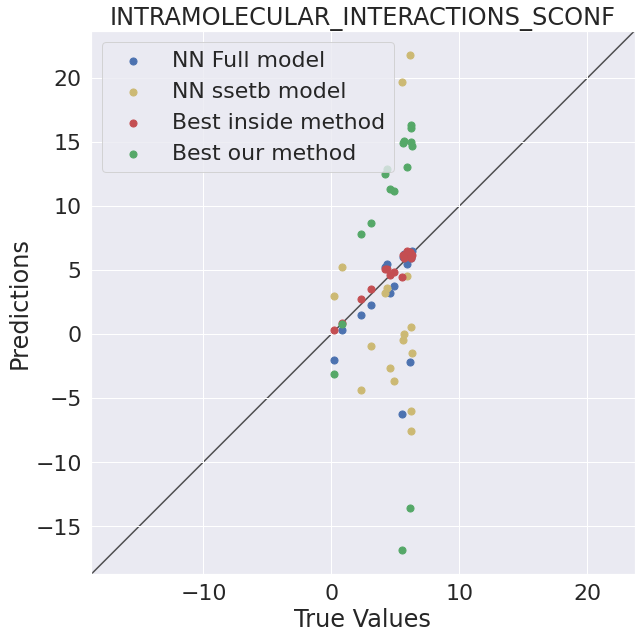

RMSE             (full)   3.507
RMSE             (sset)  18.176
RMSE (bestinsidemethod)   0.563
RMSE    (bestourmethod)   3.427


<Figure size 720x720 with 0 Axes>

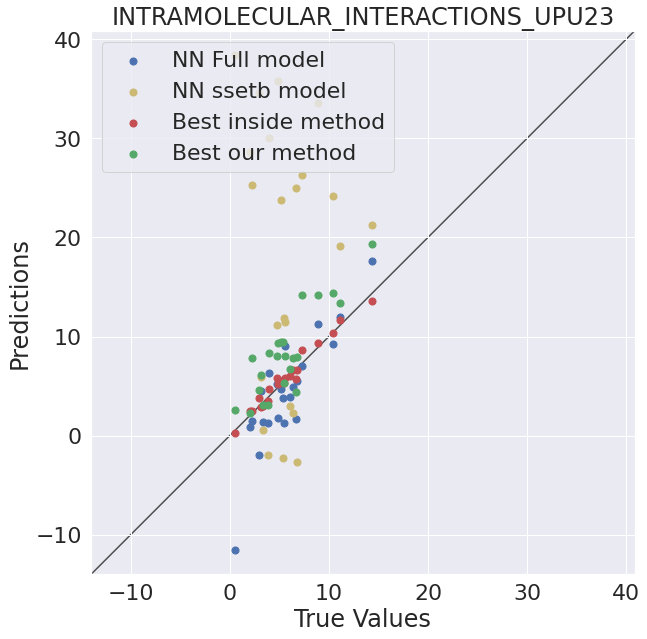

RMSE             (full)  20.111
RMSE             (sset)  33.566
RMSE (bestinsidemethod)  12.191
RMSE    (bestourmethod)  42.492


<Figure size 720x720 with 0 Axes>

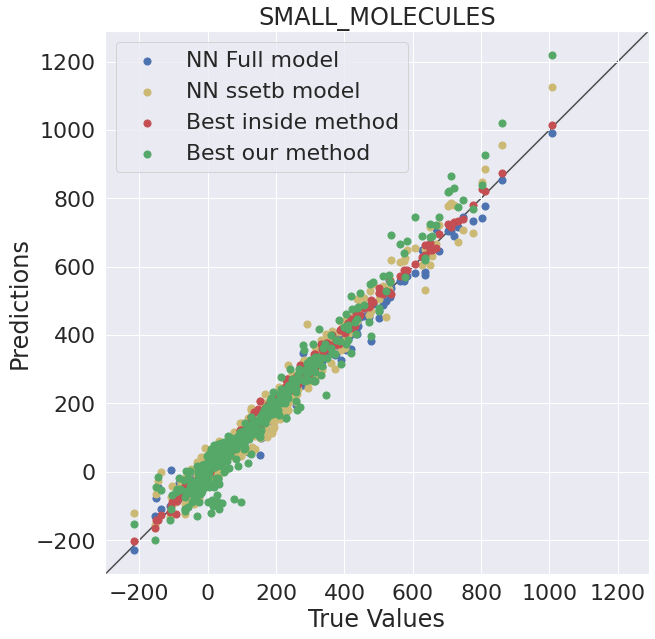

RMSE             (full)   6.660
RMSE             (sset)   9.218
RMSE (bestinsidemethod)   2.505
RMSE    (bestourmethod)  14.374


<Figure size 720x720 with 0 Axes>

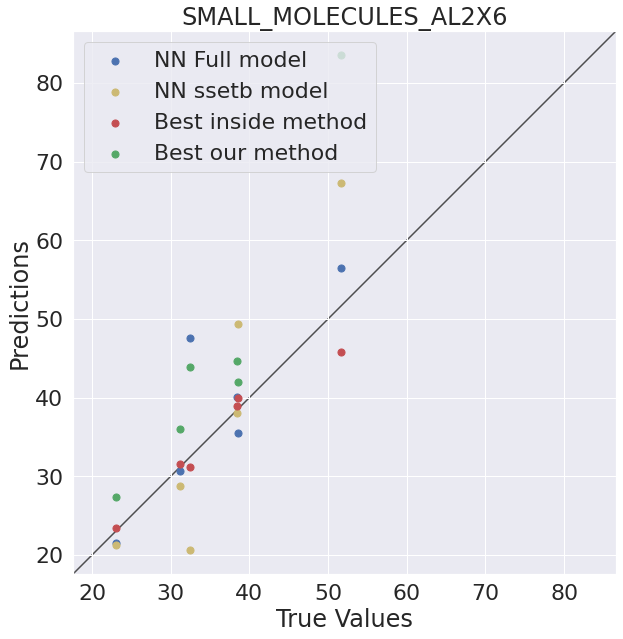

RMSE             (full)   4.715
RMSE             (sset)  22.651
RMSE (bestinsidemethod)   3.553
RMSE    (bestourmethod)  13.393


<Figure size 720x720 with 0 Axes>

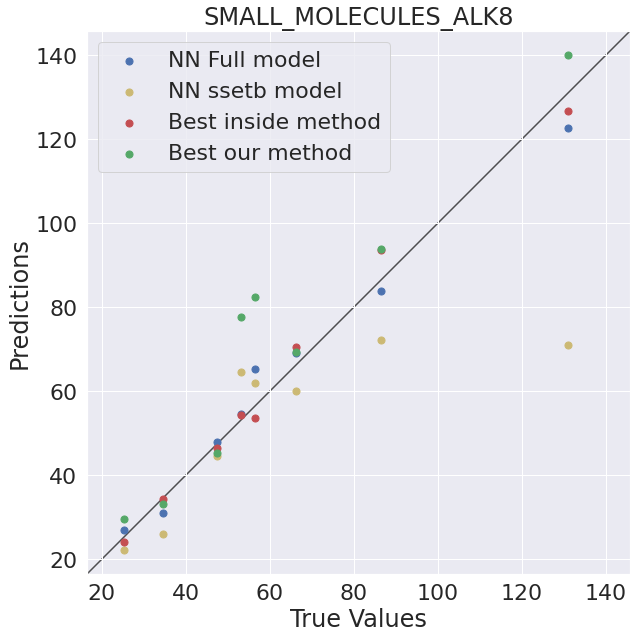

RMSE             (full)  23.553
RMSE             (sset)  30.487
RMSE (bestinsidemethod)  10.191
RMSE    (bestourmethod)  70.527


<Figure size 720x720 with 0 Axes>

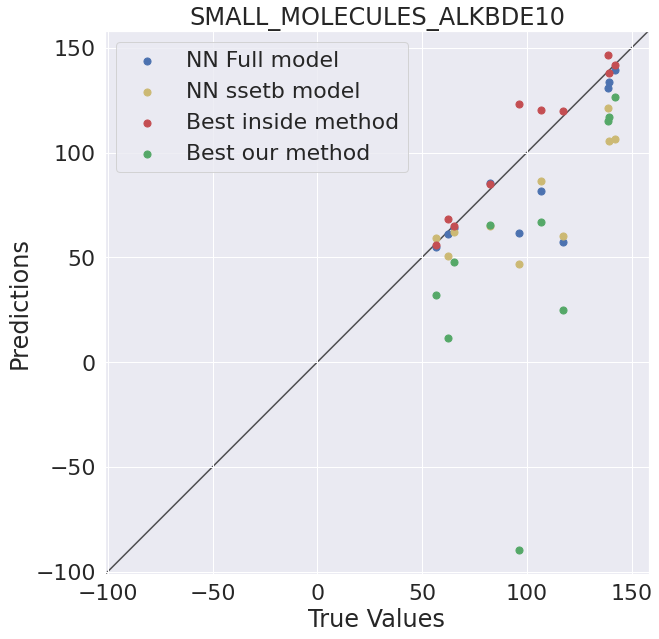

RMSE             (full)  14.502
RMSE             (sset)  26.491
RMSE (bestinsidemethod)   6.040
RMSE    (bestourmethod)  31.360


<Figure size 720x720 with 0 Axes>

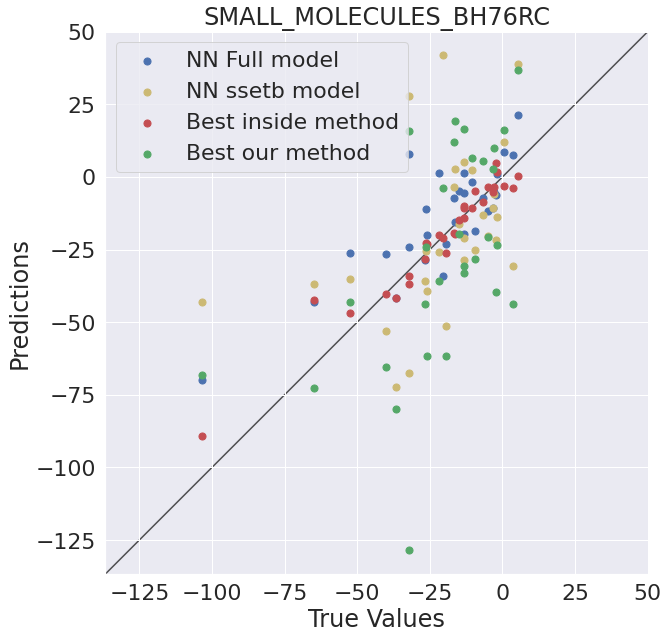

RMSE             (full)  44.157
RMSE             (sset)  33.055
RMSE (bestinsidemethod)  12.167
RMSE    (bestourmethod)  32.193


<Figure size 720x720 with 0 Axes>

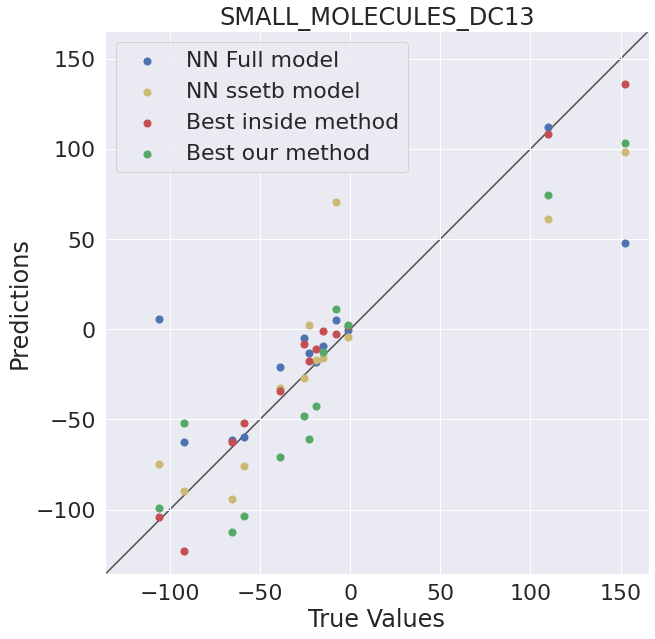

RMSE             (full)  29.275
RMSE             (sset)  55.150
RMSE (bestinsidemethod)   5.986
RMSE    (bestourmethod)  39.667


<Figure size 720x720 with 0 Axes>

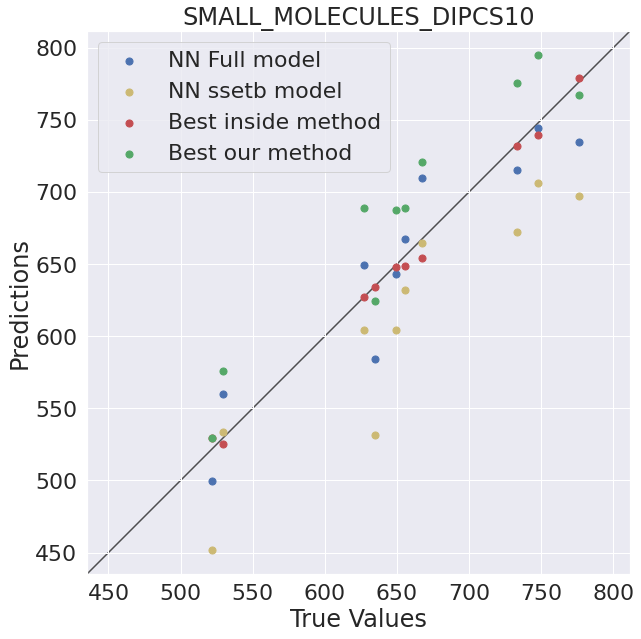

RMSE             (full)  23.881
RMSE             (sset)  28.791
RMSE (bestinsidemethod)   4.379
RMSE    (bestourmethod)  33.394


<Figure size 720x720 with 0 Axes>

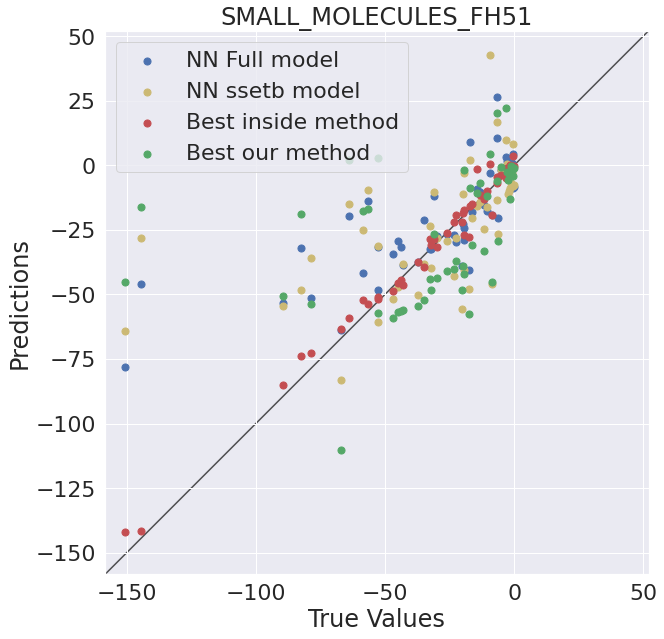

RMSE             (full)  19.300
RMSE             (sset)  29.555
RMSE (bestinsidemethod)   4.107
RMSE    (bestourmethod)  83.226


<Figure size 720x720 with 0 Axes>

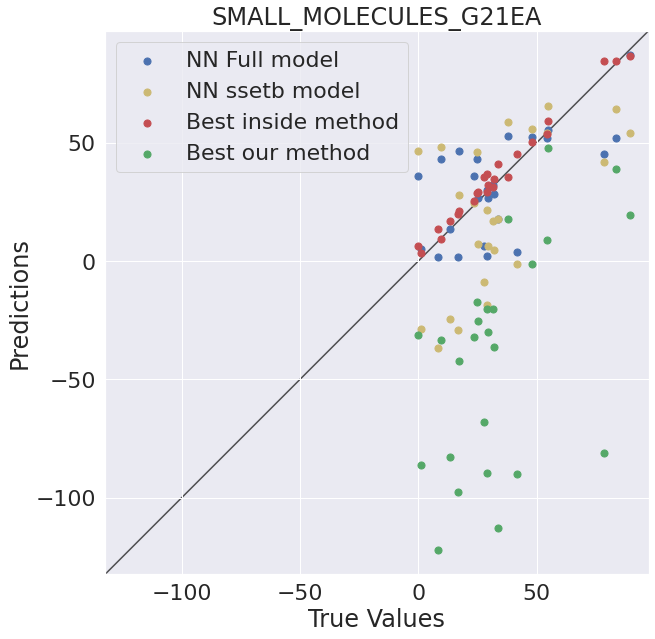

RMSE             (full)  15.578
RMSE             (sset)  30.699
RMSE (bestinsidemethod)   4.835
RMSE    (bestourmethod)  21.426


<Figure size 720x720 with 0 Axes>

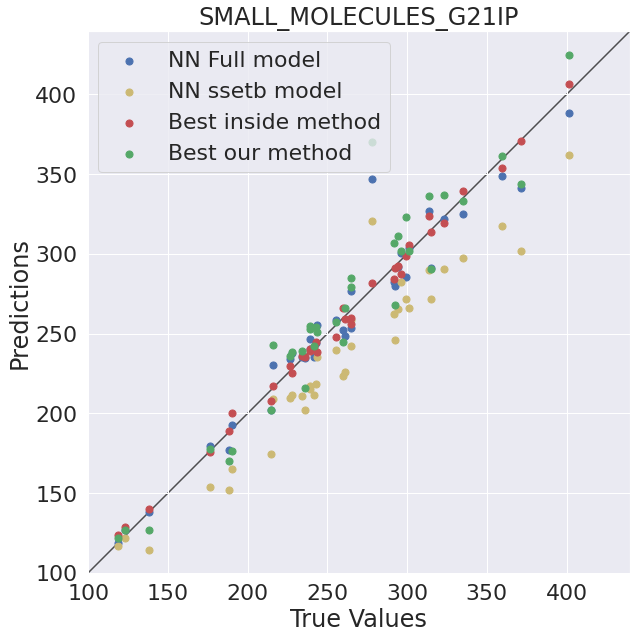

RMSE             (full)  19.278
RMSE             (sset)  45.736
RMSE (bestinsidemethod)   7.746
RMSE    (bestourmethod)  31.792


<Figure size 720x720 with 0 Axes>

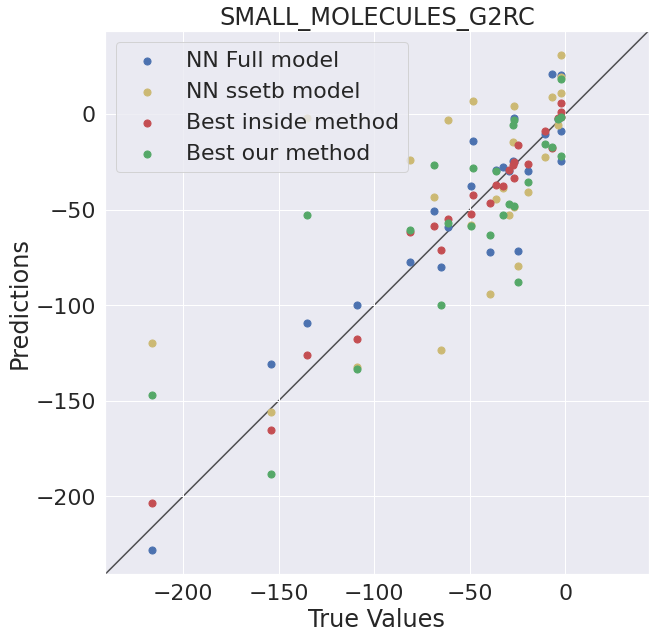

RMSE             (full)   5.879
RMSE             (sset)   9.466
RMSE (bestinsidemethod)   3.921
RMSE    (bestourmethod)   2.711


<Figure size 720x720 with 0 Axes>

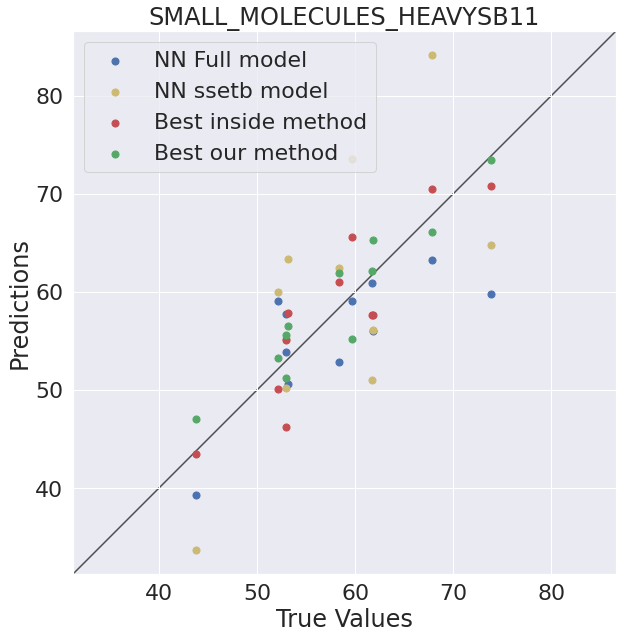

RMSE             (full)   4.328
RMSE             (sset)  18.299
RMSE (bestinsidemethod)   2.798
RMSE    (bestourmethod)  18.563


<Figure size 720x720 with 0 Axes>

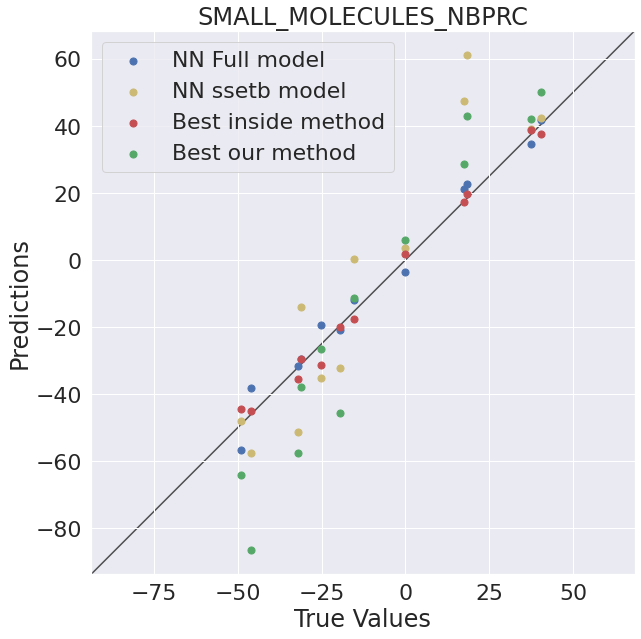

RMSE             (full)  20.614
RMSE             (sset)  49.114
RMSE (bestinsidemethod)   2.673
RMSE    (bestourmethod)  14.617


<Figure size 720x720 with 0 Axes>

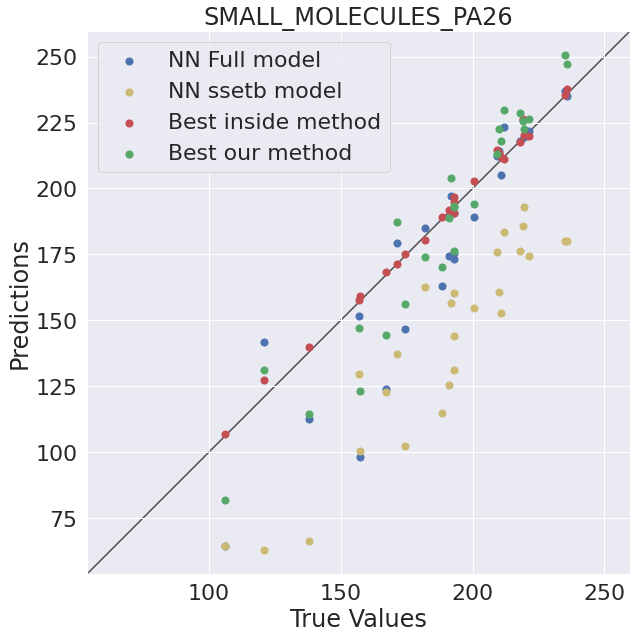

RMSE             (full)  13.234
RMSE             (sset)  30.613
RMSE (bestinsidemethod)   6.400
RMSE    (bestourmethod)  28.175


<Figure size 720x720 with 0 Axes>

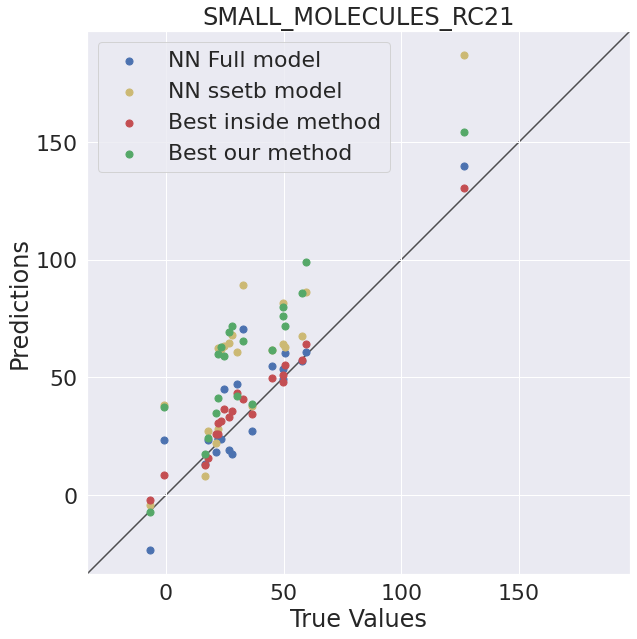

RMSE             (full)  18.583
RMSE             (sset)  29.188
RMSE (bestinsidemethod)  26.188
RMSE    (bestourmethod)  29.087


<Figure size 720x720 with 0 Axes>

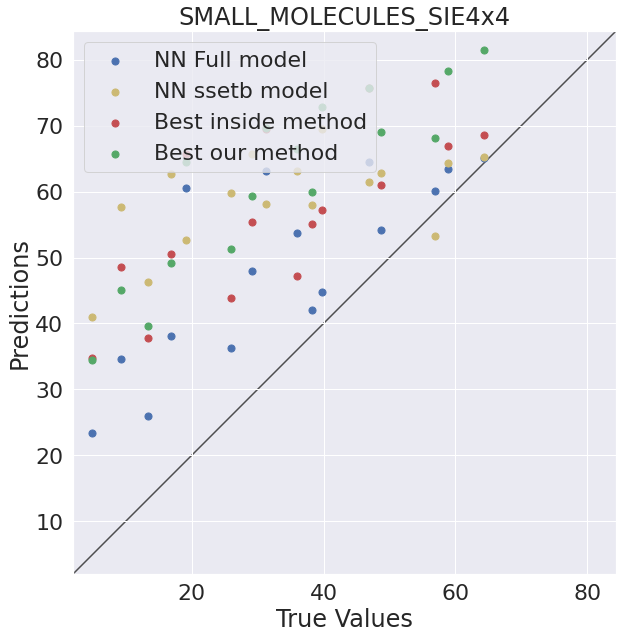

RMSE             (full)   7.469
RMSE             (sset)  10.045
RMSE (bestinsidemethod)   2.185
RMSE    (bestourmethod)   8.235


<Figure size 720x720 with 0 Axes>

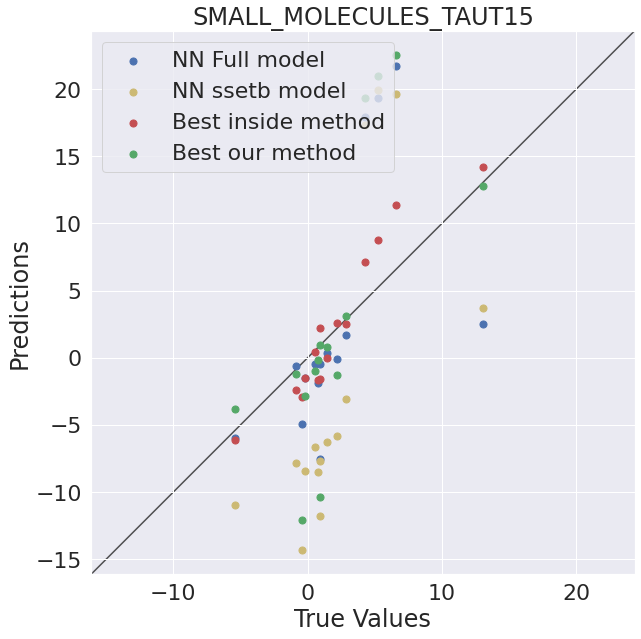

RMSE             (full)  21.815
RMSE             (sset)  37.247
RMSE (bestinsidemethod)  18.505
RMSE    (bestourmethod)  53.358


<Figure size 720x720 with 0 Axes>

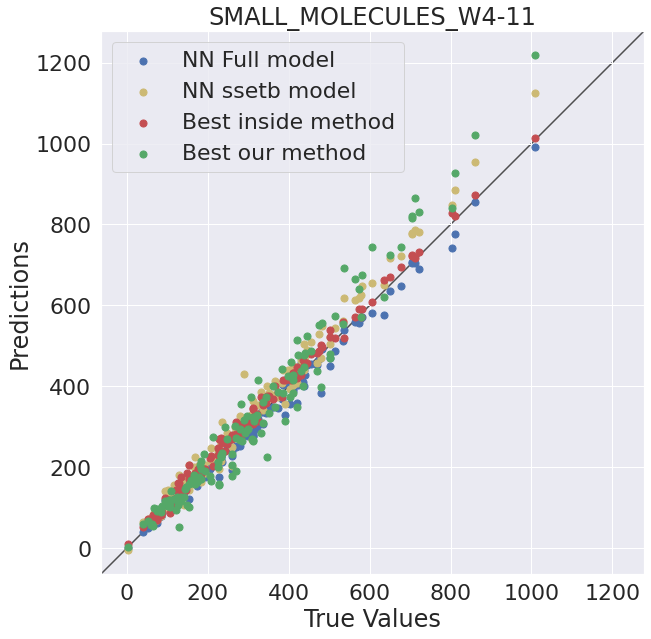

RMSE             (full)   4.351
RMSE             (sset)  18.581
RMSE (bestinsidemethod)   5.767
RMSE    (bestourmethod)  11.003


<Figure size 720x720 with 0 Axes>

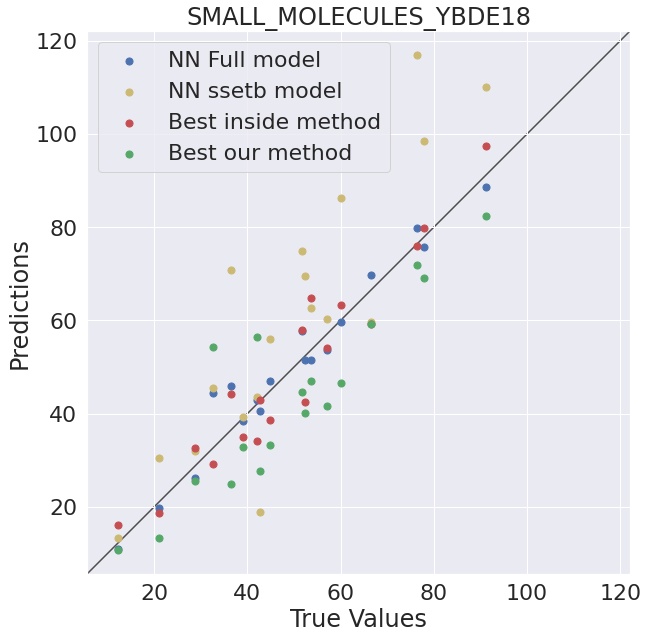

RMSE             (full)   6.749
RMSE             (sset)  51.093
RMSE (bestinsidemethod)   2.286
RMSE    (bestourmethod)  63.566


<Figure size 720x720 with 0 Axes>

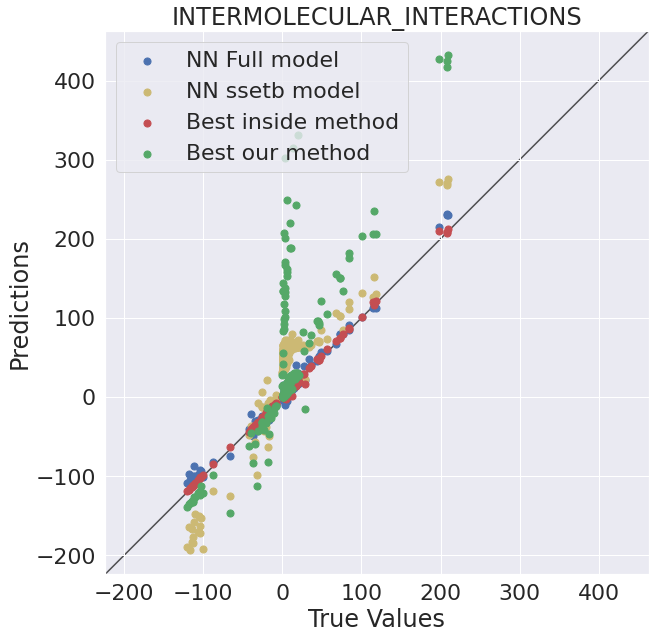

RMSE             (full)   2.616
RMSE             (sset)  60.254
RMSE (bestinsidemethod)   0.214
RMSE    (bestourmethod)   0.079


<Figure size 720x720 with 0 Axes>

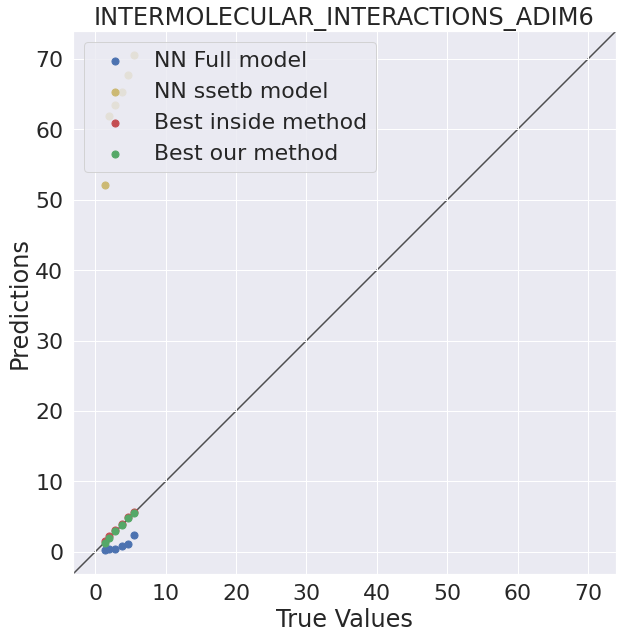

RMSE             (full)   5.433
RMSE             (sset)  26.832
RMSE (bestinsidemethod)   1.038
RMSE    (bestourmethod)  25.474


<Figure size 720x720 with 0 Axes>

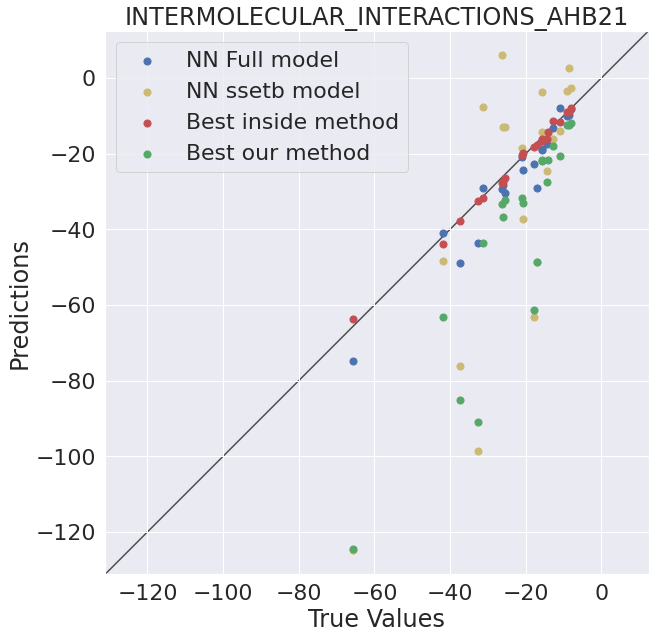

RMSE             (full)   1.523
RMSE             (sset)  43.550
RMSE (bestinsidemethod)   1.563
RMSE    (bestourmethod)   5.289


<Figure size 720x720 with 0 Axes>

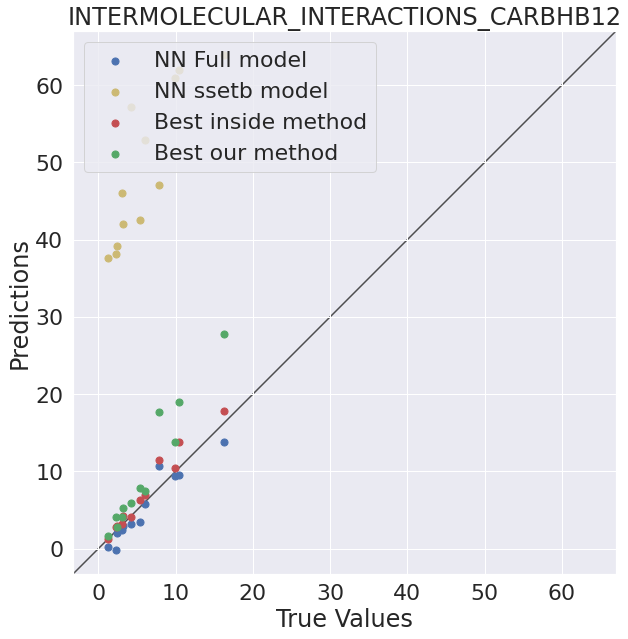

RMSE             (full)   8.261
RMSE             (sset)  21.397
RMSE (bestinsidemethod)   0.823
RMSE    (bestourmethod)  13.708


<Figure size 720x720 with 0 Axes>

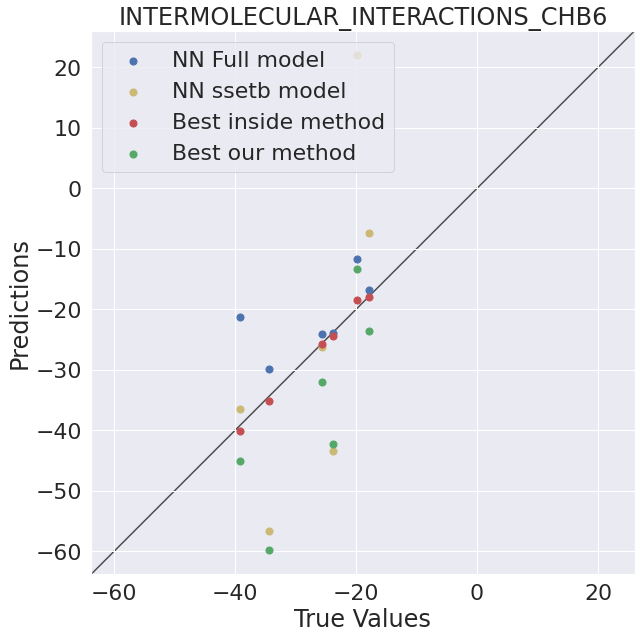

RMSE             (full)  10.149
RMSE             (sset)  58.569
RMSE (bestinsidemethod)   1.639
RMSE    (bestourmethod) 121.932


<Figure size 720x720 with 0 Axes>

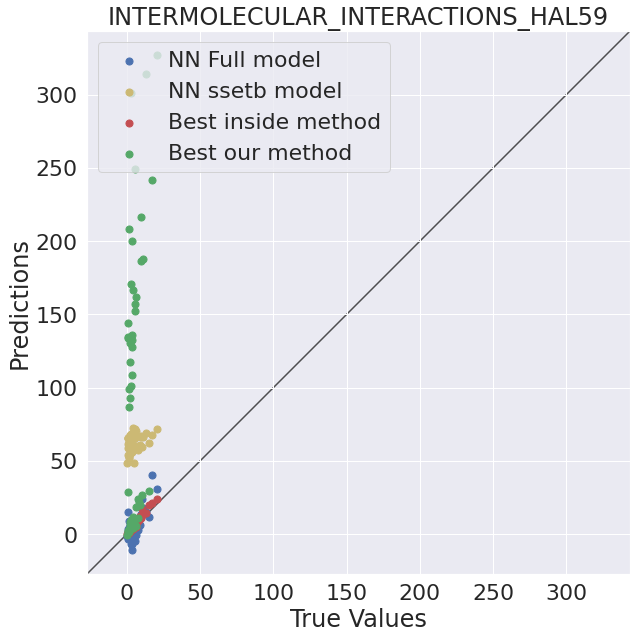

RMSE             (full)   1.705
RMSE             (sset)  50.085
RMSE (bestinsidemethod)   0.372
RMSE    (bestourmethod)   2.990


<Figure size 720x720 with 0 Axes>

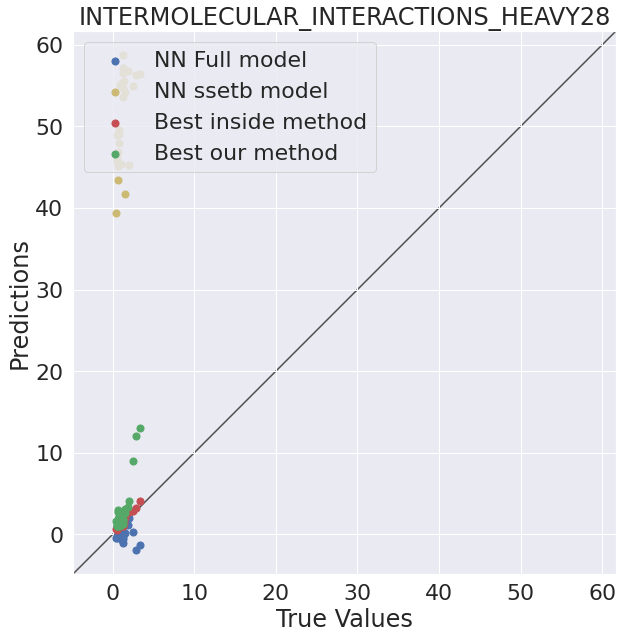

RMSE             (full)  12.090
RMSE             (sset)  60.739
RMSE (bestinsidemethod)   0.657
RMSE    (bestourmethod)  16.322


<Figure size 720x720 with 0 Axes>

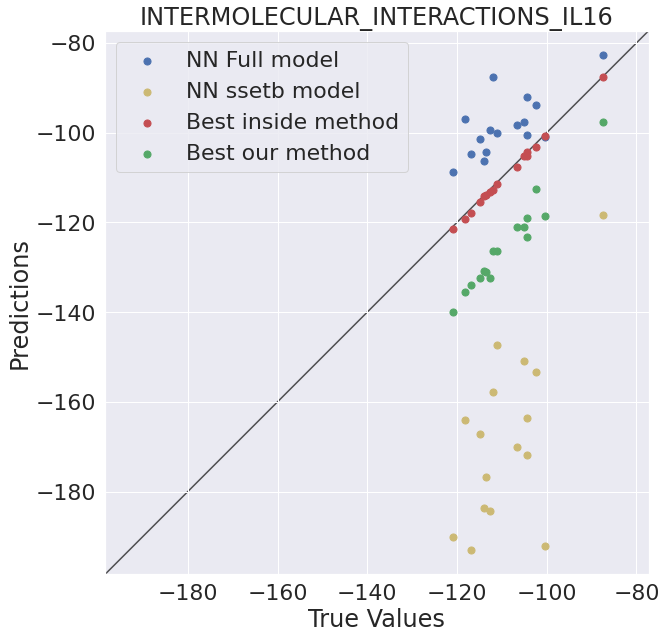

RMSE             (full)   1.985
RMSE             (sset)  52.932
RMSE (bestinsidemethod)   1.298
RMSE    (bestourmethod)   4.758


<Figure size 720x720 with 0 Axes>

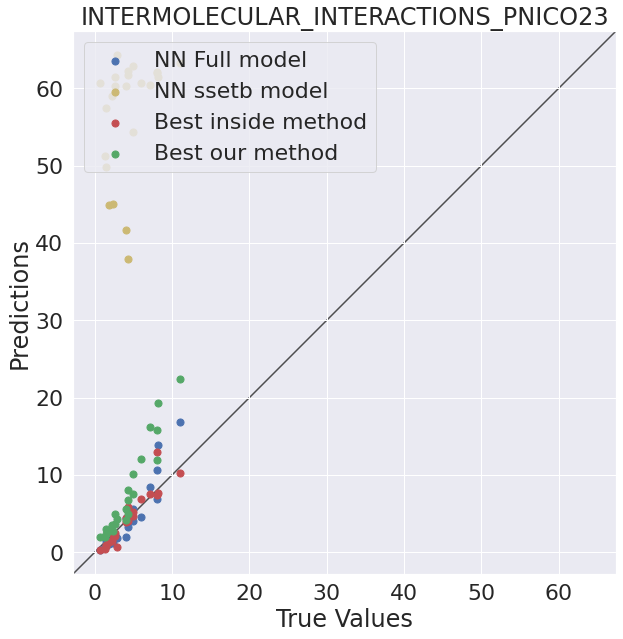

RMSE             (full)   1.096
RMSE             (sset)  44.259
RMSE (bestinsidemethod)   0.314
RMSE    (bestourmethod)   0.235


<Figure size 720x720 with 0 Axes>

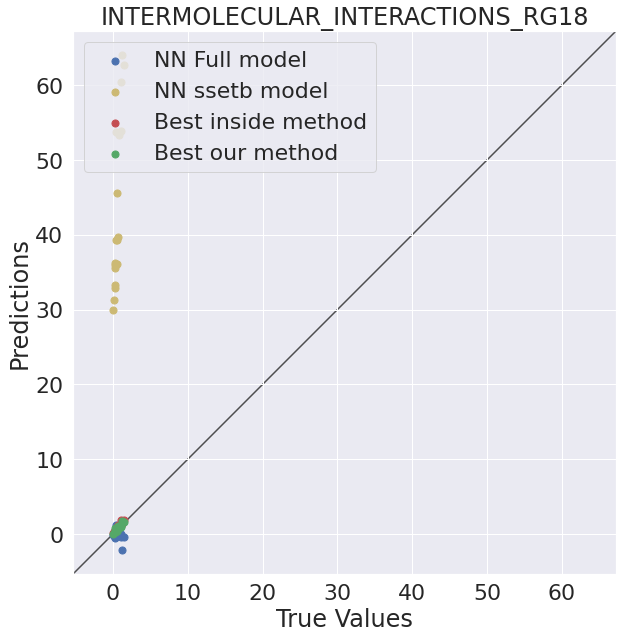

RMSE             (full)   2.270
RMSE             (sset)  52.657
RMSE (bestinsidemethod)   0.634
RMSE    (bestourmethod)   4.481


<Figure size 720x720 with 0 Axes>

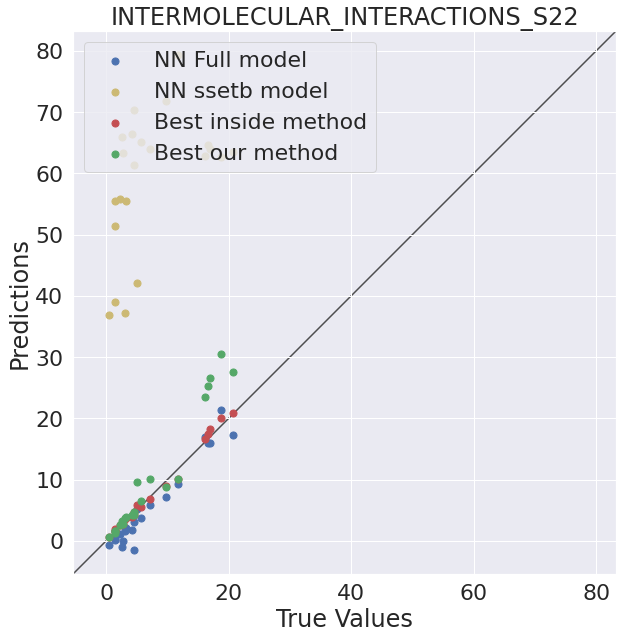

RMSE             (full)   2.060
RMSE             (sset)  55.241
RMSE (bestinsidemethod)   0.525
RMSE    (bestourmethod)   2.885


<Figure size 720x720 with 0 Axes>

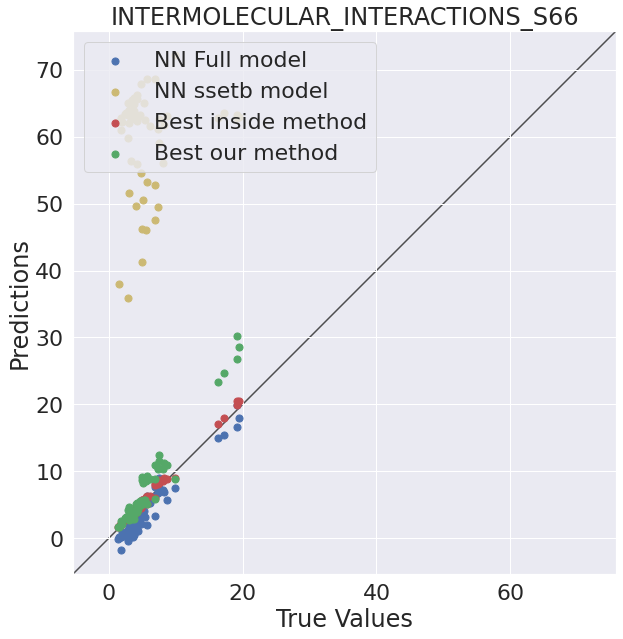

RMSE             (full)  11.780
RMSE             (sset)  37.236
RMSE (bestinsidemethod)   3.884
RMSE    (bestourmethod) 104.707


<Figure size 720x720 with 0 Axes>

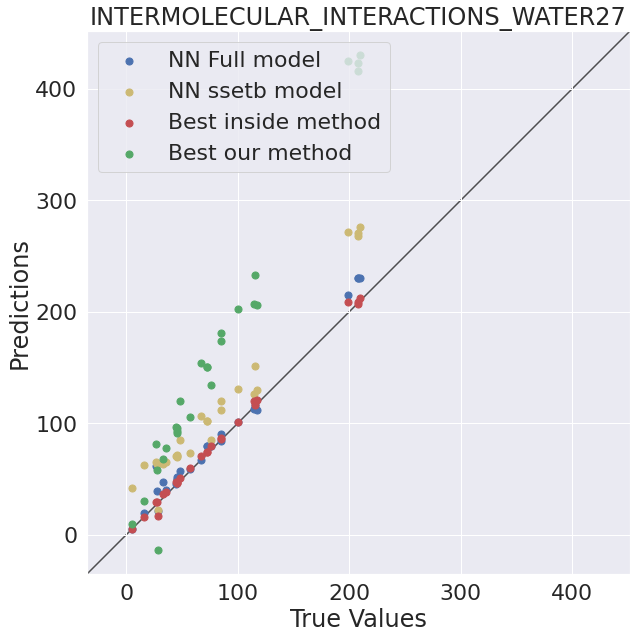

RMSE             (full)  33.335
RMSE             (sset)  60.012
RMSE (bestinsidemethod)  12.567
RMSE    (bestourmethod)  36.122


<Figure size 720x720 with 0 Axes>

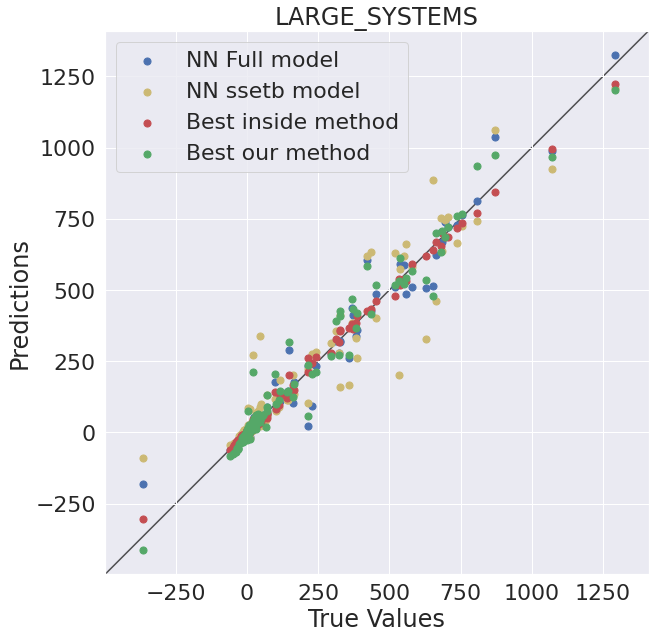

RMSE             (full)   2.152
RMSE             (sset)  16.891
RMSE (bestinsidemethod)   3.785
RMSE    (bestourmethod)   2.541


<Figure size 720x720 with 0 Axes>

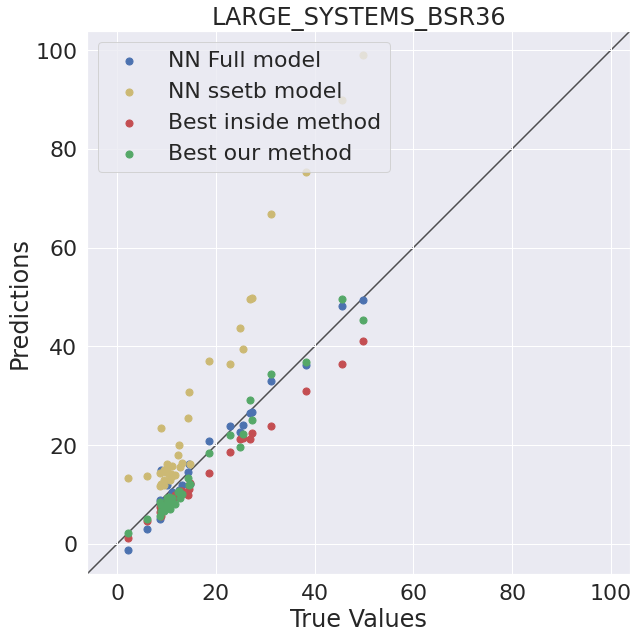

RMSE             (full)   9.395
RMSE             (sset)  21.744
RMSE (bestinsidemethod)  12.799
RMSE    (bestourmethod)   2.620


<Figure size 720x720 with 0 Axes>

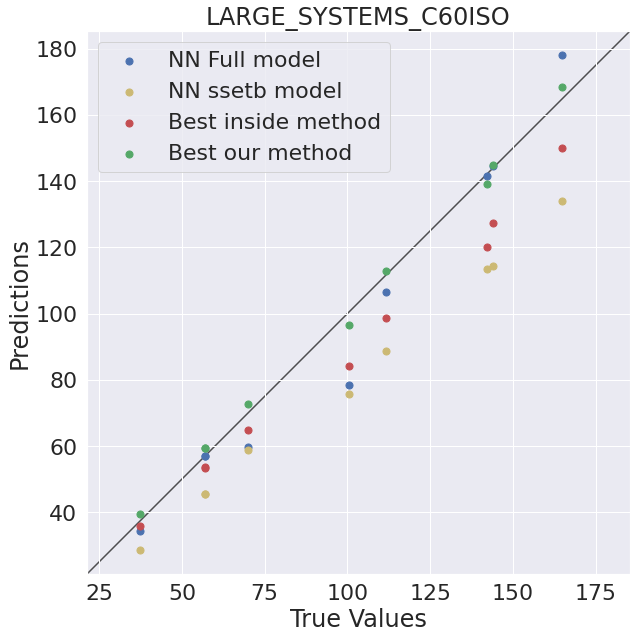

RMSE             (full)   1.264
RMSE             (sset)   3.442
RMSE (bestinsidemethod)   1.781
RMSE    (bestourmethod)   1.523


<Figure size 720x720 with 0 Axes>

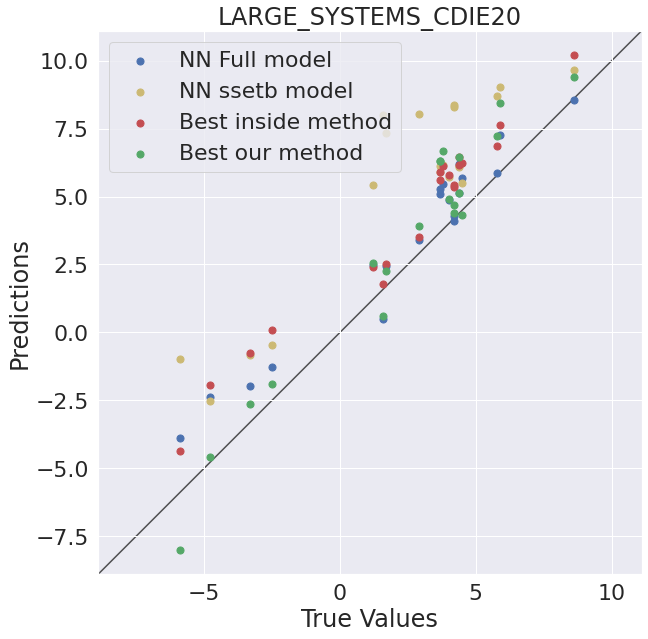

RMSE             (full)   2.443
RMSE             (sset)   7.216
RMSE (bestinsidemethod)   3.649
RMSE    (bestourmethod)  22.712


<Figure size 720x720 with 0 Axes>

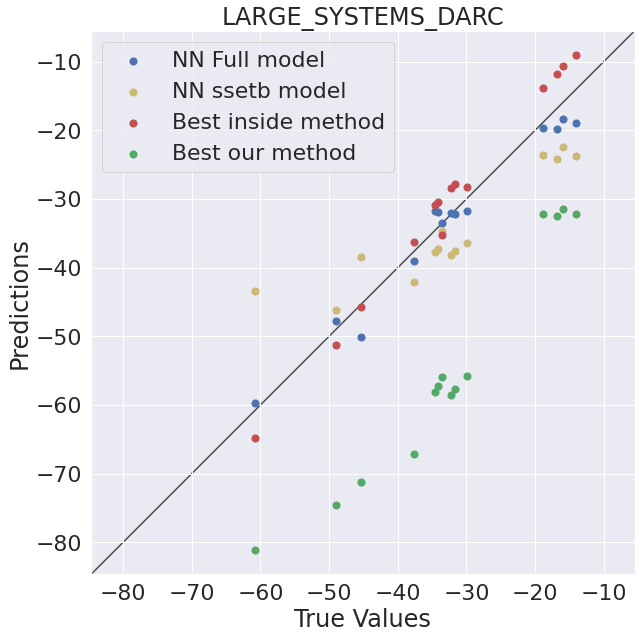

RMSE             (full)   6.340
RMSE             (sset)   8.356
RMSE (bestinsidemethod)   2.081
RMSE    (bestourmethod)  11.429


<Figure size 720x720 with 0 Axes>

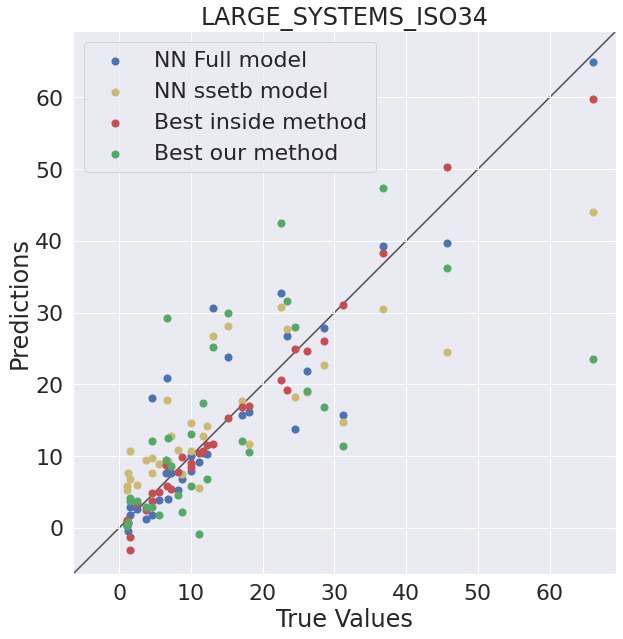

RMSE             (full)  11.251
RMSE             (sset)  27.197
RMSE (bestinsidemethod)   6.365
RMSE    (bestourmethod)  22.733


<Figure size 720x720 with 0 Axes>

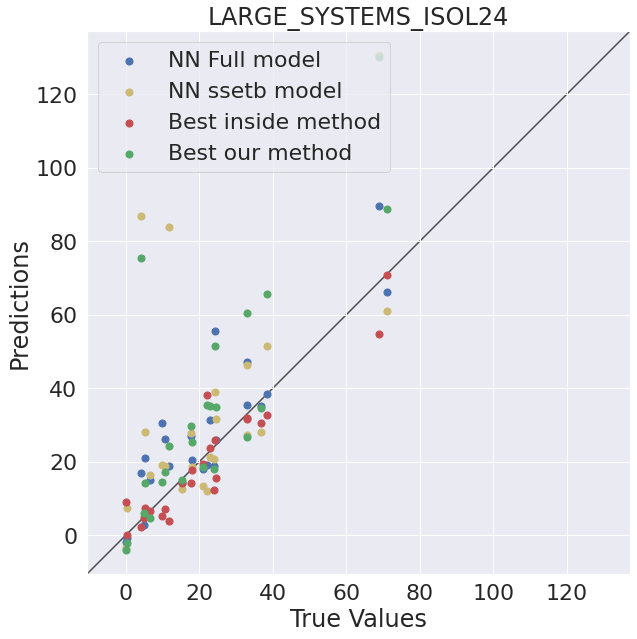

RMSE             (full)  78.236
RMSE             (sset) 139.144
RMSE (bestinsidemethod)  27.916
RMSE    (bestourmethod)  81.741


<Figure size 720x720 with 0 Axes>

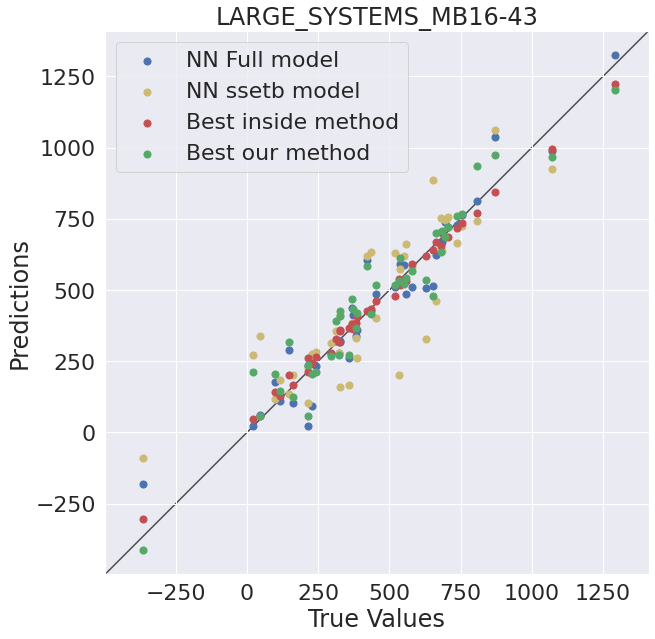

RMSE             (full)   7.530
RMSE             (sset)  10.115
RMSE (bestinsidemethod)   2.525
RMSE    (bestourmethod)  12.374


<Figure size 720x720 with 0 Axes>

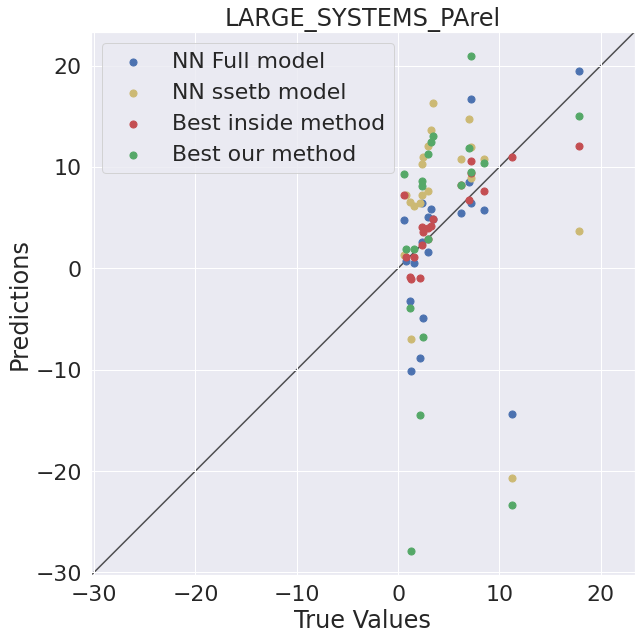

RMSE             (full)   2.279
RMSE             (sset)  10.730
RMSE (bestinsidemethod)   3.188
RMSE    (bestourmethod)   5.049


<Figure size 720x720 with 0 Axes>

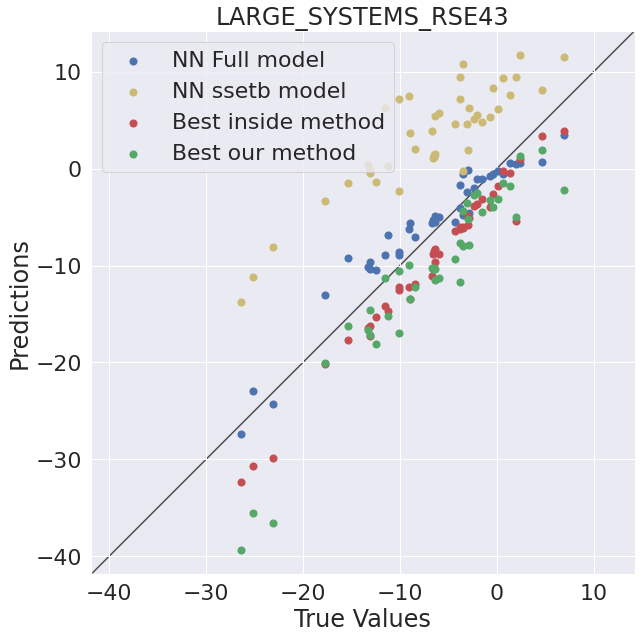

RMSE             (full)  18.045
RMSE             (sset)  18.045
RMSE (bestinsidemethod)   9.227
RMSE    (bestourmethod)  41.931


<Figure size 720x720 with 0 Axes>

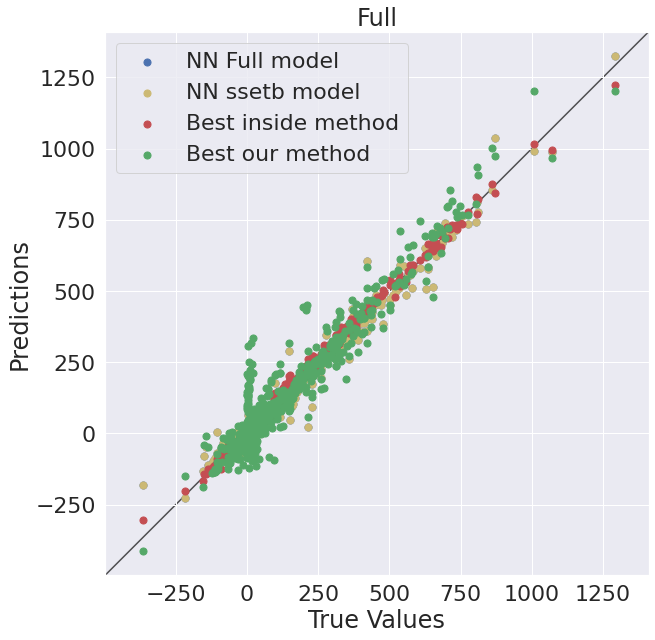

In [18]:
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    y_pred = models_results[setname].y_pred 
    rmse = mean_squared_error(Y, y_pred, squared=False)
    y_pred_sset = models_results[setname].y_pred_sset
    rmse_sset = mean_squared_error(Y, y_pred_sset, squared=False)
    #mape = mean_absolute_percentage_error(Y, y_pred)
    #r2 = r2_score(Y, y_pred)

    print("RMSE             (full) %7.3f"%rmse)
    print("RMSE             (sset) %7.3f"%rmse_sset)
    print("RMSE (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)

    #print("MAPE ", setname, " : %6.2f"%mape)
    #print("R2   ", setname, " : %6.2f"%r2)
    
    #y_pred_mape = models_results[setname].y_pred_mape
    #rmse = mean_squared_error(Y, y_pred_mape, squared=False)
    #mape = mean_absolute_percentage_error(Y, y_pred_mape)
    #r2 = r2_score(Y, y_pred_mape)
    #print("RMSE MAPE", setname, " : %6.2f"%rmse)
    #print("MAPE MAPE", setname, " : %6.2f"%mape)
    #print("R2   MAPE", setname, " : %6.2f"%r2)
    plt.clf()
    #plt.scatter(Y, y_pred)

    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred, c='b', s=50, label='NN Full model')
    ax.scatter(Y, y_pred_sset, c='y', s=50, label='NN ssetb model')
    ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
                c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()